## Initialization

In [1]:
# import matplotlib.pyplot as plt
import pickle
import torch
import torchviz
from CST2 import *
from qiskit.quantum_info import DensityMatrix
import matplotlib.pyplot as plt
device = torch.device('cuda') # 'cpu', 'cuda', 'mps' ...

d:\programing\Anaconda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\programing\Anaconda\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
d:\programing\Anaconda\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
torch.cuda.is_available()

True

In [3]:
torch.__version__

'2.1.2+cu121'

d:\programing\Anaconda\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


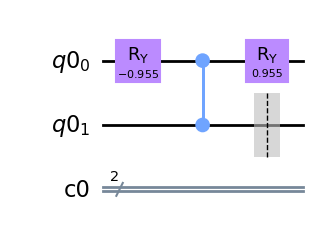

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister
n = 2
q = QuantumRegister(n)
c = ClassicalRegister(n)
W_states = QuantumCircuit(q,c) 

F_gate(W_states,q,1,0,2,0)
W_states.draw(output='mpl')

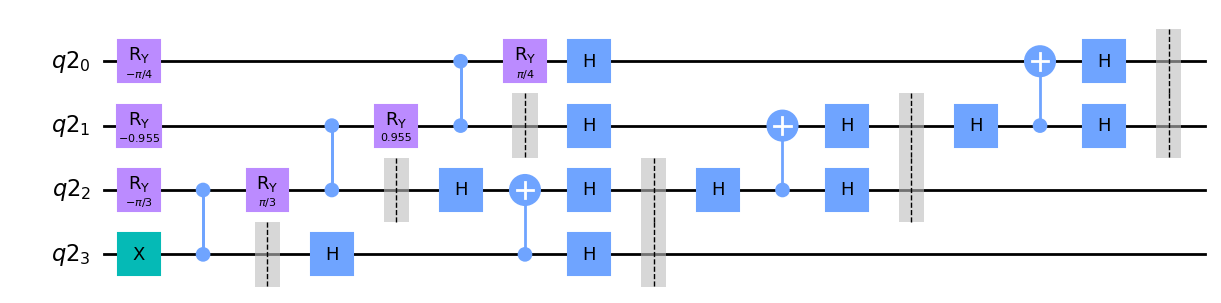

In [4]:
circuit=w_state(4)[1]
circuit.draw(output='mpl')

## Testing

### Transformer

#### Test 1: Log Probability Estimation


**Goal:** show that the log probability accumulated at sampling is the same as log probability evaluated by the model directly.

In [3]:
tf = Transformer(outtk_size=2)
tf.eval()
x = torch.tensor([[4],[4],[5],[5],[6],[6]])

In [4]:
y, logprob = tf.sample(x, 1, need_logprob=True)
y, logprob

(tensor([[2],
         [1],
         [1],
         [2],
         [2],
         [1]]),
 tensor([-1.0728, -0.4186, -0.3737, -1.1653, -1.3932, -0.2854]))

In [5]:
tf.logprob(x, y)

tensor([-1.0728, -0.4186, -0.3737, -1.1653, -1.3932, -0.2854],
       grad_fn=<SumBackward1>)

#### Test 2: Generative Modeling
**Goal:** test the ability of the transformer model to learn sequence-to-sequence map.

In [6]:
tf = Transformer(outtk_size=2)
x = torch.tensor([[4],[4],[5],[5],[6],[6],[6]])
y = torch.tensor([[1],[1],[1],[2],[1],[2],[2]])
y1 = torch.tensor([[1],[2],[1],[2],[1],[2],[2]])


optimizer = torch.optim.Adam(tf.parameters(), lr=0.001)

tf.train()
for epoch in range(10):
    optimizer.zero_grad()
    loss = -tf.logprob(x, y).mean()
    loss.backward()
    optimizer.step()
    print('{:3d}: {:8.5g}'.format(epoch, loss.item()))

  0:  0.77397
  1:  0.68991
  2:  0.65507
  3:  0.60556
  4:  0.57676
  5:  0.53575
  6:  0.52872
  7:  0.49114
  8:  0.48082
  9:  0.48632


Learns to predict $y$ from $x$.

In [7]:
tf.eval()
tf.logprob(x, y1).exp().tolist()

[0.9695141911506653,
 0.030485866591334343,
 0.46847498416900635,
 0.5315250158309937,
 0.258935809135437,
 0.741064190864563,
 0.741064190864563]

#### Test 3: VAE loss
**Goal**: test training the transformer with VAE bottleneck

In [8]:
tf = Transformer(outtk_size=2)
x = torch.tensor([[4],[4],[5],[5],[6],[6],[6]])
y = torch.tensor([[1],[1],[1],[2],[1],[2],[2]])
y1 = torch.tensor([[1],[2],[1],[2],[1],[2],[2]])
optimizer = torch.optim.Adam(tf.parameters(), lr=0.001)
tf.train()
for epoch in range(10):
    optimizer.zero_grad()
    loss, logprob, kld = tf.loss(x, y, beta=0.)
    loss.backward()
    optimizer.step()
    print(f'{epoch:3d}: {loss.item():8.5g} {logprob.item():8.5g} {kld.item():8.5g}')


  0:  0.76708 -0.76708   1.0787
  1:  0.71408 -0.71408   1.1062
  2:  0.61857 -0.61857   1.1157
  3:  0.66372 -0.66372   1.1269
  4:  0.58534 -0.58534   1.1234
  5:  0.60851 -0.60851   1.1136
  6:  0.60058 -0.60058    1.112
  7:  0.50943 -0.50943    1.123
  8:  0.60598 -0.60598   1.1274
  9:  0.51564 -0.51564   1.1476


Learns to predict $y$ from $x$.
Now the accuracy can be controlled by the hyperparameter $\beta$.

In [9]:
tf.eval()
tf.logprob(x, y1).exp().tolist()

[0.9179153442382812,
 0.08208466321229935,
 0.5231319665908813,
 0.47686803340911865,
 0.3011154234409332,
 0.6988845467567444,
 0.6988845467567444]

#### Test 4: Sampling
**Goal**: test sampling and completion.

In [10]:
tf = Transformer(outtk_size=2)
x = torch.randint(4,7,(3,5))
print(tf.sample(x))

tensor([[1, 2, 2, 2],
        [1, 2, 2, 2],
        [2, 2, 2, 2]])


Completion task.

In [11]:
y = torch.randint(1,3,(3,2))
print(y)
print(tf.sample(x, tgt_seq=y))

tensor([[1, 2],
        [1, 1],
        [2, 1]])
tensor([[1, 2, 1, 1],
        [1, 1, 2, 1],
        [2, 1, 2, 1]])


### Operator

#### Test 1: Operator Algebra

In [12]:
ops = [pauli([i]) for i in range(4)]
ops

[I, X, Y, Z]

Multiplication table of Pauli operators

In [13]:
for op1 in ops: 
    for op2 in ops:
        print(f'{op1} @ {op2} = {op1 @ op2}')

I @ I = I
I @ X = X
I @ Y = Y
I @ Z = Z
X @ I = X
X @ X = I
X @ Y = i Z
X @ Z = -i Y
Y @ I = Y
Y @ X = -i Z
Y @ Y = I
Y @ Z = i X
Z @ I = Z
Z @ X = i Y
Z @ Y = -i X
Z @ Z = I


#### Test 2: Operator Gradient

In [14]:
O = pauli('X') + 1j * pauli('Y') - 2 * pauli('Z')
O

X + i Y -2 Z

### Shdaow

#### Test 1: Shadow Evaluate 
**Goal:** evaluate operator expectation value on a shadow dataset.

In [15]:
n_qubit=3
rho = w_state(n_qubit)
sigma = shadow(n_qubit,1)

print(rho,'\n',sigma)

(Statevector([-1.75276195e-17+0.j,  5.77350269e-01+0.j,  5.77350269e-01+0.j,
             -1.75276195e-17+0.j,  5.77350269e-01+0.j,  1.31992390e-17+0.j,
             -1.75276195e-17+0.j,  2.50131920e-34+0.j],
            dims=(2, 2, 2)), <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001312C7D2280>) 
 ['YXY']


### ClassicalShdow Transformer

#### Test 1: Sampling

**Goal**: test sampling and state reconstruction

In [16]:
cst = ClassicalShadowTransformer(2,0,state_name='w_state')


Reconstruct density operator (matrix).

In [17]:
rho = cst.rho()
print(rho,"\n")
rhomat = rho.matrix_form() / 2**2
print(rhomat)

1.00 II + 0.07 IX + 0.05 IY -0.02 IZ + 0.26 XI + 0.33 XX + 0.34 XY + 0.36 XZ + 0.31 YI + 0.35 YX + 0.34 YY + 0.31 YZ + 0.24 ZI + 0.34 ZX + 0.34 ZY + 0.32 ZZ (grad_fn=<class 'SqueezeBackward3'>) 

tensor([[ 0.3864+0.0000e+00j,  0.1032-9.6912e-02j,  0.1537-1.5656e-01j,
         -0.0021-1.7412e-01j],
        [ 0.1032+9.6912e-02j,  0.2354+0.0000e+00j,  0.1688-2.2197e-03j,
         -0.0248-5.1908e-05j],
        [ 0.1537+1.5656e-01j,  0.1688+2.2197e-03j,  0.1055+0.0000e+00j,
         -0.0677+7.0969e-02j],
        [-0.0021+1.7412e-01j, -0.0248+5.1908e-05j, -0.0677-7.0969e-02j,
          0.2726+0.0000e+00j]], grad_fn=<DivBackward0>)


In [18]:
torch.linalg.eigvalsh(rhomat)

tensor([-0.1061,  0.0980,  0.3707,  0.6374], grad_fn=<LinalgEighBackward>)

## Trainning

### Batch Trainning

Scaning over parameter space and train a collection of models of different number of qubits and hyperparameter $\beta$. <br>
`max_steps` - maximal optimization step, <br>
`nsr` - the noise signal ratio threshold for the loss function flucturation (optimization stop when the noise signal ratio is larger than this threshold), <br>
`window` - the window size used to estimate noise signal ratio (larger window size stricter convergence criterion), <br>
`n_sample` - number of classical shadow samples used in each iteration, <br>
`lr` -  learning rate.<br>
`state_name` - certain state you want to generate and be trainned

#### Sample data

In [76]:
for n_qubit in range(1,7):
    cst = ClassicalShadowTransformer(n_qubit, logbeta=1,state_name='GHZ').to(device).load()
    cst.sample(n_sample=400,sample_size=200)

In [77]:
for n_qubit in range(1,7):
    cst = ClassicalShadowTransformer(n_qubit, logbeta=1,state_name='W_state').to(device).load()
    cst.sample(n_sample=400,sample_size=200)

In [78]:
for n_qubit in range(1,7):
    cst = ClassicalShadowTransformer(n_qubit, logbeta=1,state_name='Zero_state').to(device).load()
    cst.sample(n_sample=400,sample_size=200)

#### Train the model

In [2]:
for logbeta in range(-6,7):
        for dim in [256,128,64,32]:
            cst = ClassicalShadowTransformer(5, logbeta,embed_dim=dim,state_name='GHZ').to(device).load()
            cst.optimize(steps=2000, max_steps=1000, nsr=32, window=1000, n_sample=400, lr=0.0001)

./model/CST_d32_h16_l1/GHZ_N5_b6
999:  4.15703 -3.41454  0.01160 -0.00001


In [123]:
for n_qubit in range(1,6):
    for logbeta in range(-6,7):
        for dim in [256,128,64,32]:
            cst = ClassicalShadowTransformer(n_qubit, logbeta,embed_dim=dim,state_name='GHZ').to(device).load()
            cst.optimize(steps=2000, max_steps=1000, nsr=32, window=1000, n_sample=400, lr=0.0001)

./model/CST_d128_h16_l1/GHZ_N5_b-6
493:  3.08806 -3.06174  1.68445 -0.01388


In [3]:
for n_qubit in range(1,6):
    for logbeta in range(-6,7):
        for dim in [256,128,64,32]:
            cst = ClassicalShadowTransformer(n_qubit, logbeta,embed_dim=dim,state_name='W_state').to(device).load()
            cst.optimize(steps=2000, max_steps=1000, nsr=32, window=100, n_sample=400, lr=0.0001)

./model/CST_d32_h16_l1/W_state_N5_b6
999:  4.18340 -3.33631  0.01324 -0.00005


In [76]:
for n_qubit in range(1,6):
    for logbeta in range(-6,7):
        for dim in [256,128,64,32]:
            cst = ClassicalShadowTransformer(n_qubit, logbeta,embed_dim=dim,state_name='Zero_state').to(device).load()
            cst.optimize(steps=1500, max_steps=1000, nsr=32, window=100, n_sample=400, lr=0.0001)

./model/CST_d32_h16_l1/Zero_state_N5_b6
999:  3.77051 -3.24353  0.00823 -0.00012


scan over the number of qubits and dimensionality of embeded space,selcet log $\beta$  =1

In [50]:
for n_qubit in range(1,7):
    for dim in [256,128,64,32]:
        cst = ClassicalShadowTransformer(n_qubit=n_qubit, logbeta=-5,state_name='GHZ',embed_dim=dim).to(device).load()
        cst.optimize(2000, max_steps=1000, nsr=32, window=100, n_sample=400, lr=0.0001)

./model/CST_d32_h16_l1/GHZ_N6_b-5
1999:  3.54324 -3.49777  1.45484 -0.19470


In [51]:
for n_qubit in range(1,7):
   for dim in [256,128,64,32]: 
        cst = ClassicalShadowTransformer(n_qubit=n_qubit, logbeta=-5,state_name='Zero_state',embed_dim=dim).to(device).load()
        cst.optimize(2000, max_steps=1000, nsr=32, window=100, n_sample=400, lr=0.0001)

./model/CST_d32_h16_l1/Zero_state_N6_b-5
1999:  2.84686 -2.82454  0.71427 -0.13729


In [52]:
for n_qubit in range(1,7):
    for dim in [256,128,64,32]:
        cst = ClassicalShadowTransformer(n_qubit=n_qubit, logbeta=-5,state_name='W_state',embed_dim=dim).to(device).load()
        cst.optimize(2000, max_steps=1000, nsr=32, window=100, n_sample=400, lr=0.0001)

./model/CST_d32_h16_l1/W_state_N6_b-5
1999:  3.59393 -3.56937  0.78578 -0.16503


In [54]:
cst = ClassicalShadowTransformer(5,logbeta=-4,state_name='GHZ').load()
obs, out = cst.shadowmeasure(1)
print(obs,out)

tensor([[2, 1, 2, 2, 1]]) tensor([[1, 0, 1, 1, 1]])


In [12]:
n_sample=400
sample_file_path = os.path.join('./sample',f'{cst.state_name}_{cst.n_qubit}_{n_sample}.pkl')
with open(sample_file_path, 'rb') as file:
    sample_data = pickle.load(file)
all_obs = sample_data['obs']
all_out = sample_data['out']
obs=all_obs[1]
out=all_out[1]
Shadow(obs,out)

| -Z -Z +X -Z -X |
| +Z -Y +Y +X +Z |
| -Z -Z -Z -X -X |
| +Z +Y +Z -Y +X |
| +Z +Z -Y -Y -X |
| -Y +Y +Y -X +X |
| +Y -X -X -X +Y |
| +X +Z +Z +Z +X |
| -X +X -Z -Y -Y |
| +Y +Z +Y +Z -Z |
| +Z +Z +Z +X +Z |
| +Z -X -Y +X +Z |
| +Y +Y +Y +Z -Z |
| -Z +X +X +Y -Y |
| +Z +Z +Z +Z +Z |
| -Y -Y -Z -Y -Z |
...

### Fine Tunning

If necessary, a model can be loaded for fine tuning with smaller training rate to ensure convergence.

In [ ]:
cst = ClassicalShadowTransformer(5, -6).load()
cst.optimize(100, max_steps=1000, nsr=32, window=1000, n_sample=1000, lr=0.00001)

## Evaluation

### Loss Function Hostory

In [4]:
def smooth_data(data, window_size):
    """
    Smooths the data using a moving average filter.

    :param data: A list or numpy array containing the data to be smoothed.
    :param window_size: The size of the window used for smoothing, 
                        it should be an odd integer.
    :return: A numpy array containing the smoothed data.
    """
    if window_size % 2 == 0:
        raise ValueError("Window size should be an odd integer")

    half_window = window_size // 2
    padded_data = np.pad(data, (half_window, half_window), mode='edge')
    smoothed_data = np.convolve(padded_data, np.ones(window_size) / window_size, mode='valid')

    return smoothed_data

In [2]:
state=['GHZ','W_state','Zero_state']
for s in state:
    logbeta=-5
    cst = ClassicalShadowTransformer(5,logbeta,s,embed_dim=32).load()
    smoothed_data = smooth_data(cst.loss_history[0:4000], window_size=15)
    plt.plot(smoothed_data, label=s)


# Add a legend to the plot
plt.legend()
# plt.yscale( "log")
# Show the plot
plt.show()
    

SyntaxError: invalid character '：' (U+FF1A) (2217250314.py, line 5)

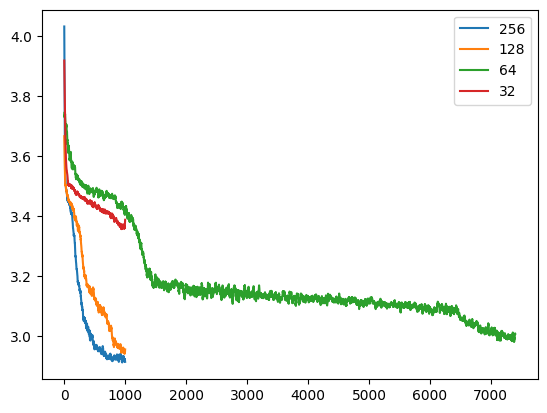

In [118]:
for dim in [256,128,64,32]:
    cst = ClassicalShadowTransformer(5,logbeta=-4,embed_dim=dim,state_name='GHZ').load()
    smoothed_data = smooth_data(cst.loss_history, window_size=15)
    plt.plot(smoothed_data, label=dim)
    plt.legend()

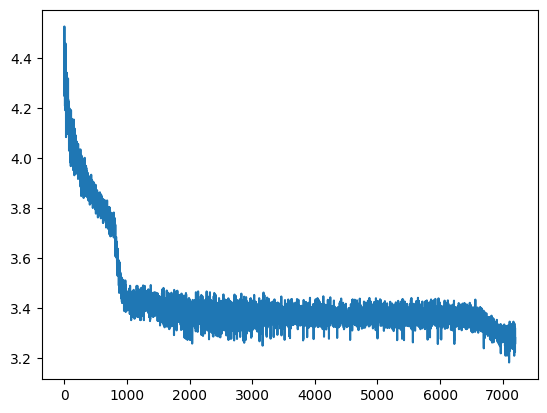

In [7]:

cst = ClassicalShadowTransformer(5,logbeta=-1,embed_dim=64,state_name='GHZ').load()
#print(cst.transformer.repara.logvar)
plt.plot(cst.loss_history)

### Fidelity and Entropy Map
Compute `fidelity` and `entropy `(in unit of bit) of the reconstructed density matrix.

using `map.data`

#### over n-qubits nad dimensionality, log $\beta$ =1

In [107]:
def fidelity(state_name,rho,n_qubit):
    state_list={'GHZ':ghz_state,
                'W_state':w_state,
                'Zero_state':zero_state}
    state_vector=state_list[state_name](n_qubit)[0].data
    density_Mat=rho.data
    return state_vector.conjugate().dot(density_Mat@state_vector)

In [108]:
data = []
for n_qubit in range(1,6):
    for dim in [256,128,64,32]:
        cst = ClassicalShadowTransformer(n_qubit=n_qubit, logbeta=-5,state_name='Zero_state',embed_dim=dim).load().eval()
        with torch.no_grad():
            rho = cst.rho().matrix_form()/2**cst.n_qubit # reconstruction
        # compute fidelity
        fid=fidelity(cst.state_name,rho,cst.n_qubit)
        vals = torch.linalg.eigvalsh(rho)
        vals = vals[vals > 0.]
        ent = -torch.log2(vals).dot(vals).item()
     
        ##
        clear_output(wait=True)
        print(cst.path + '/' + cst.file)
        print(f'F = {fid}, S = {ent}')
        data.append([n_qubit, dim, fid, ent])

./model/CST_d32_h16_l1/Zero_state_N5_b-5
F = (0.9973263144493103+0j), S = 0.1656809151172638


##### `Zero_state`

C:\Users\86991\AppData\Local\Temp\ipykernel_9348\1899157.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  n = int(n_qubit[i] - 1)
C:\Users\86991\AppData\Local\Temp\ipykernel_9348\1899157.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  d = dim_values.index(int(dim[i]))  # 获取维度在取值列表中的索引
C:\Users\86991\AppData\Local\Temp\ipykernel_9348\1899157.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  fid_matrix[n, d] = fid[i]
C:\Users\86991\AppData\Local\Temp\ipykernel_9348\1899157.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  ent_matrix[n, d] = ent[i]


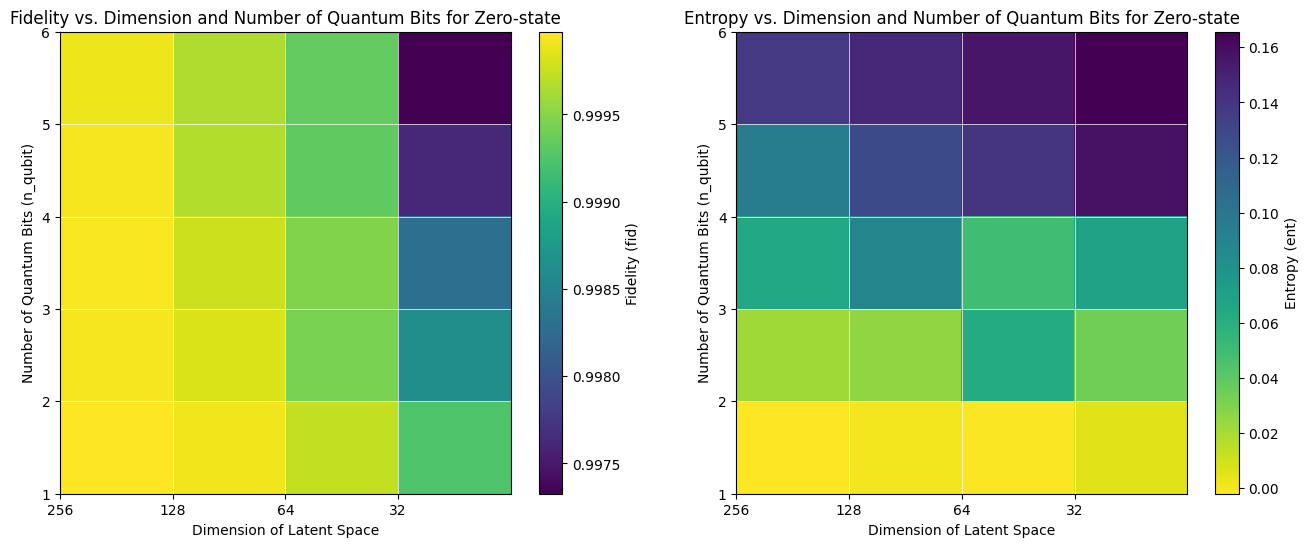

In [109]:
import matplotlib.pyplot as plt
import numpy as np

# 从 data 列表中提取数据并转换为 NumPy 数组
data_array = np.array(data)

# 提取量子比特数、logbeta、保真度和熵列
n_qubit = data_array[:, 0]
dim = data_array[:, 1]
fid = data_array[:, 2]
ent = data_array[:, 3]
fid_matrix = np.zeros((5, 4))
ent_matrix = np.zeros((5, 4))
dim_values = [256, 128, 64, 32]  # 定义维度取值

# 创建一个矩阵，将 fid 和 ent 值填充到相应的位置
for i in range(len(data)):
    n = int(n_qubit[i] - 1)
    d = dim_values.index(int(dim[i]))  # 获取维度在取值列表中的索引
    fid_matrix[n, d] = fid[i]
    ent_matrix[n, d] = ent[i]


# 创建两个子图
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 绘制 Fidelity 矩阵
fid_img = axes[0].imshow(fid_matrix, cmap='viridis', extent=[0, len(dim_values), 1, 6], aspect='auto', origin='lower')
axes[0].set_xticks(np.arange(len(dim_values)))
axes[0].set_xticklabels(dim_values)
axes[0].set_xlabel('Dimension of Latent Space')
axes[0].set_ylabel('Number of Quantum Bits (n_qubit)')
axes[0].set_title('Fidelity vs. Dimension and Number of Quantum Bits for Zero-state')
axes[0].grid(color='white', linestyle='-', linewidth=0.5)  # 添加网格线
plt.colorbar(fid_img, ax=axes[0], label='Fidelity (fid)')

# 绘制 Entropy 矩阵
ent_img = axes[1].imshow(ent_matrix, cmap='viridis_r', extent=[0, len(dim_values), 1, 6], aspect='auto', origin='lower')
axes[1].set_xticks(np.arange(len(dim_values)))
axes[1].set_xticklabels(dim_values)
axes[1].set_xlabel('Dimension of Latent Space')
axes[1].set_ylabel('Number of Quantum Bits (n_qubit)')
axes[1].set_title('Entropy vs. Dimension and Number of Quantum Bits for Zero-state')
axes[1].grid(color='white', linestyle='-', linewidth=0.5)  # 添加网格线
plt.colorbar(ent_img, ax=axes[1], label='Entropy (ent)')

plt.show()


##### `w_state`

C:\Users\86991\AppData\Local\Temp\ipykernel_9348\3390991525.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  n = int(n_qubit[i] - 1)
C:\Users\86991\AppData\Local\Temp\ipykernel_9348\3390991525.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  d = dim_values.index(int(dim[i]))  # 获取维度在取值列表中的索引
C:\Users\86991\AppData\Local\Temp\ipykernel_9348\3390991525.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  fid_matrix[n, d] = fid[i]
C:\Users\86991\AppData\Local\Temp\ipykernel_9348\3390991525.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  ent_matrix[n, d] = ent[i]


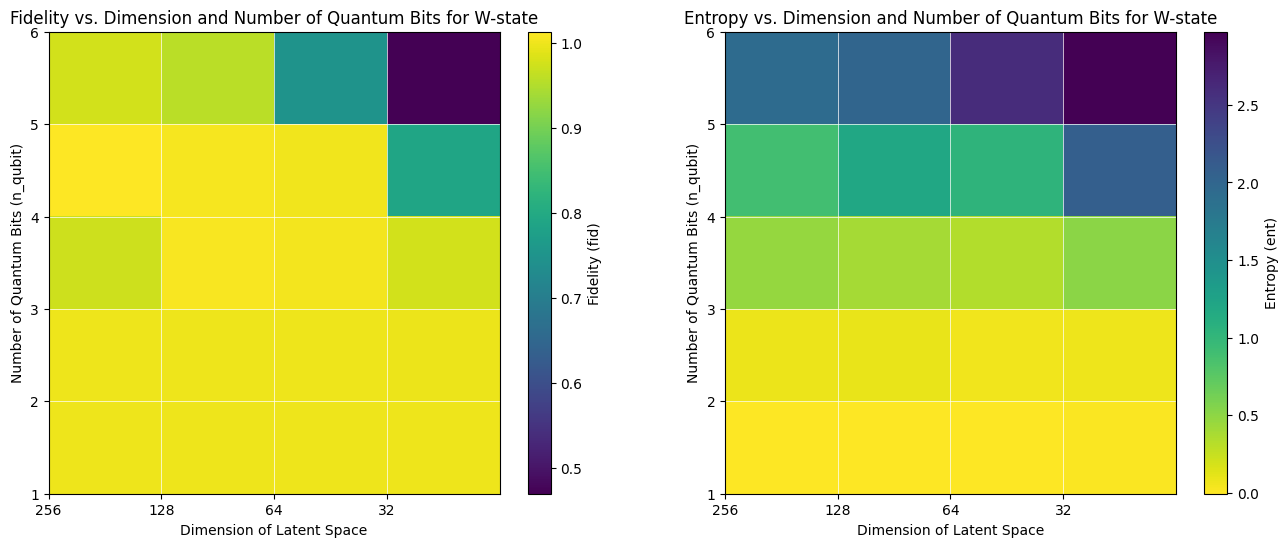

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# 从 data 列表中提取数据并转换为 NumPy 数组
data_array = np.array(data)

# 提取量子比特数、logbeta、保真度和熵列
n_qubit = data_array[:, 0]
dim = data_array[:, 1]
fid = data_array[:, 2]
ent = data_array[:, 3]
fid_matrix = np.zeros((5, 4))
ent_matrix = np.zeros((5, 4))
dim_values = [256, 128, 64, 32]  # 定义维度取值

# 创建一个矩阵，将 fid 和 ent 值填充到相应的位置
for i in range(len(data)):
    n = int(n_qubit[i] - 1)
    d = dim_values.index(int(dim[i]))  # 获取维度在取值列表中的索引
    fid_matrix[n, d] = fid[i]
    ent_matrix[n, d] = ent[i]


# 创建两个子图
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 绘制 Fidelity 矩阵
fid_img = axes[0].imshow(fid_matrix, cmap='viridis', extent=[0, len(dim_values), 1, 6], aspect='auto', origin='lower')
axes[0].set_xticks(np.arange(len(dim_values)))
axes[0].set_xticklabels(dim_values)
axes[0].set_xlabel('Dimension of Latent Space')
axes[0].set_ylabel('Number of Quantum Bits (n_qubit)')
axes[0].set_title('Fidelity vs. Dimension and Number of Quantum Bits for W-state')
axes[0].grid(color='white', linestyle='-', linewidth=0.5)  # 添加网格线
plt.colorbar(fid_img, ax=axes[0], label='Fidelity (fid)')

# 绘制 Entropy 矩阵
ent_img = axes[1].imshow(ent_matrix, cmap='viridis_r', extent=[0, len(dim_values), 1, 6], aspect='auto', origin='lower')
axes[1].set_xticks(np.arange(len(dim_values)))
axes[1].set_xticklabels(dim_values)
axes[1].set_xlabel('Dimension of Latent Space')
axes[1].set_ylabel('Number of Quantum Bits (n_qubit)')
axes[1].set_title('Entropy vs. Dimension and Number of Quantum Bits for W-state')
axes[1].grid(color='white', linestyle='-', linewidth=0.5)  # 添加网格线
plt.colorbar(ent_img, ax=axes[1], label='Entropy (ent)')

plt.show()


##### `GHZ`

C:\Users\86991\AppData\Local\Temp\ipykernel_9348\180613746.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  n = int(n_qubit[i] - 1)
C:\Users\86991\AppData\Local\Temp\ipykernel_9348\180613746.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  d = dim_values.index(int(dim[i]))  # 获取维度在取值列表中的索引
C:\Users\86991\AppData\Local\Temp\ipykernel_9348\180613746.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  fid_matrix[n, d] = fid[i]
C:\Users\86991\AppData\Local\Temp\ipykernel_9348\180613746.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  ent_matrix[n, d] = ent[i]


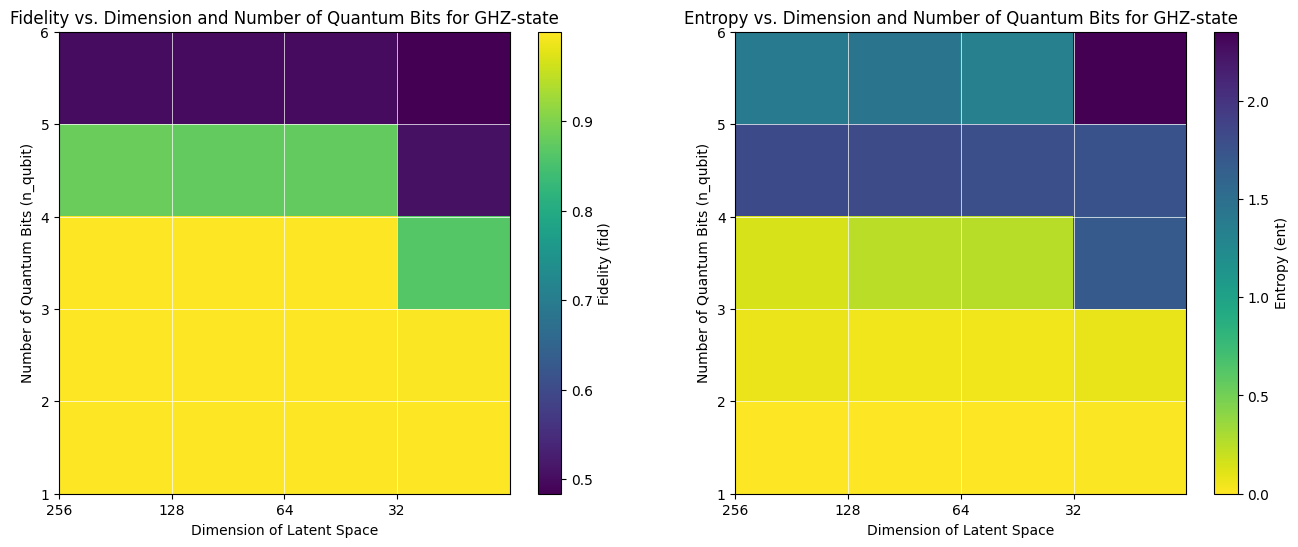

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# 从 data 列表中提取数据并转换为 NumPy 数组
data_array = np.array(data)

# 提取量子比特数、logbeta、保真度和熵列
n_qubit = data_array[:, 0]
dim = data_array[:, 1]
fid = data_array[:, 2]
ent = data_array[:, 3]
fid_matrix = np.zeros((5, 4))
ent_matrix = np.zeros((5, 4))
dim_values = [256, 128, 64, 32]  # 定义维度取值

# 创建一个矩阵，将 fid 和 ent 值填充到相应的位置
for i in range(len(data)):
    n = int(n_qubit[i] - 1)
    d = dim_values.index(int(dim[i]))  # 获取维度在取值列表中的索引
    fid_matrix[n, d] = fid[i]
    ent_matrix[n, d] = ent[i]


# 创建两个子图
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 绘制 Fidelity 矩阵
fid_img = axes[0].imshow(fid_matrix, cmap='viridis', extent=[0, len(dim_values), 1, 6], aspect='auto', origin='lower')
axes[0].set_xticks(np.arange(len(dim_values)))
axes[0].set_xticklabels(dim_values)
axes[0].set_xlabel('Dimension of Latent Space')
axes[0].set_ylabel('Number of Quantum Bits (n_qubit)')
axes[0].set_title('Fidelity vs. Dimension and Number of Quantum Bits for GHZ-state')
axes[0].grid(color='white', linestyle='-', linewidth=0.5)  # 添加网格线
plt.colorbar(fid_img, ax=axes[0], label='Fidelity (fid)')

# 绘制 Entropy 矩阵
ent_img = axes[1].imshow(ent_matrix, cmap='viridis_r', extent=[0, len(dim_values), 1, 6], aspect='auto', origin='lower')
axes[1].set_xticks(np.arange(len(dim_values)))
axes[1].set_xticklabels(dim_values)
axes[1].set_xlabel('Dimension of Latent Space')
axes[1].set_ylabel('Number of Quantum Bits (n_qubit)')
axes[1].set_title('Entropy vs. Dimension and Number of Quantum Bits for GHZ-state')
axes[1].grid(color='white', linestyle='-', linewidth=0.5)  # 添加网格线
plt.colorbar(ent_img, ax=axes[1], label='Entropy (ent)')

plt.show()


#### over `log` $\beta$  and `n-qubits`, `dim`=64

In [112]:
data = []
for n_qubit in range(1, 6):
    for logbeta in range(-6, 7):
        cst = ClassicalShadowTransformer(n_qubit,logbeta,'W_state',embed_dim=64).load().eval()
        with torch.no_grad():
            rho = cst.rho().matrix_form()/2**cst.n_qubit # reconstruction
        # compute fidelity
        fid=fidelity(cst.state_name,rho,cst.n_qubit)
        vals = torch.linalg.eigvalsh(rho)
        vals = vals[vals > 0.]
        ent = -torch.log2(vals).dot(vals).item()
        clear_output(wait=True)
        print(cst.path + '/' + cst.file)
        print(f'F = {fid}, S = {ent}')
        data.append([n_qubit, logbeta, fid, ent])

./model/CST_d64_h16_l1/W_state_N5_b6
F = (0.18471847176551767+8.470329472543003e-22j), S = 3.7993874549865723


In [121]:
data = []
#[256,128,64,32]
for dim in [256,128]:
    for n_qubit in range(1, 6):
        for logbeta in range(-6, 7):
            cst = ClassicalShadowTransformer(n_qubit,logbeta,'GHZ',embed_dim=dim).load().eval()
            with torch.no_grad():
                rho = cst.rho().matrix_form()/2**cst.n_qubit # reconstruction
            # compute fidelity
            fid=fidelity(cst.state_name,rho,cst.n_qubit)
            vals = torch.linalg.eigvalsh(rho)
            vals = vals[vals > 0.]
            ent = -torch.log2(vals).dot(vals).item()
            clear_output(wait=True)
            print(cst.path + '/' + cst.file)
            print(f'F = {fid}, S = {ent}')
            data.append([dim,n_qubit, logbeta, fid, ent])


./model/CST_d128_h16_l1/GHZ_N5_b6
F = (0.06817169999703764+0j), S = 4.479581832885742


C:\Users\86991\AppData\Local\Temp\ipykernel_9348\2240722653.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  n = int(n_qubit[j] - 1)
C:\Users\86991\AppData\Local\Temp\ipykernel_9348\2240722653.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  lb = int(logbeta[j] + 6)
C:\Users\86991\AppData\Local\Temp\ipykernel_9348\2240722653.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  fid_matrix[n, lb] = fid[j]


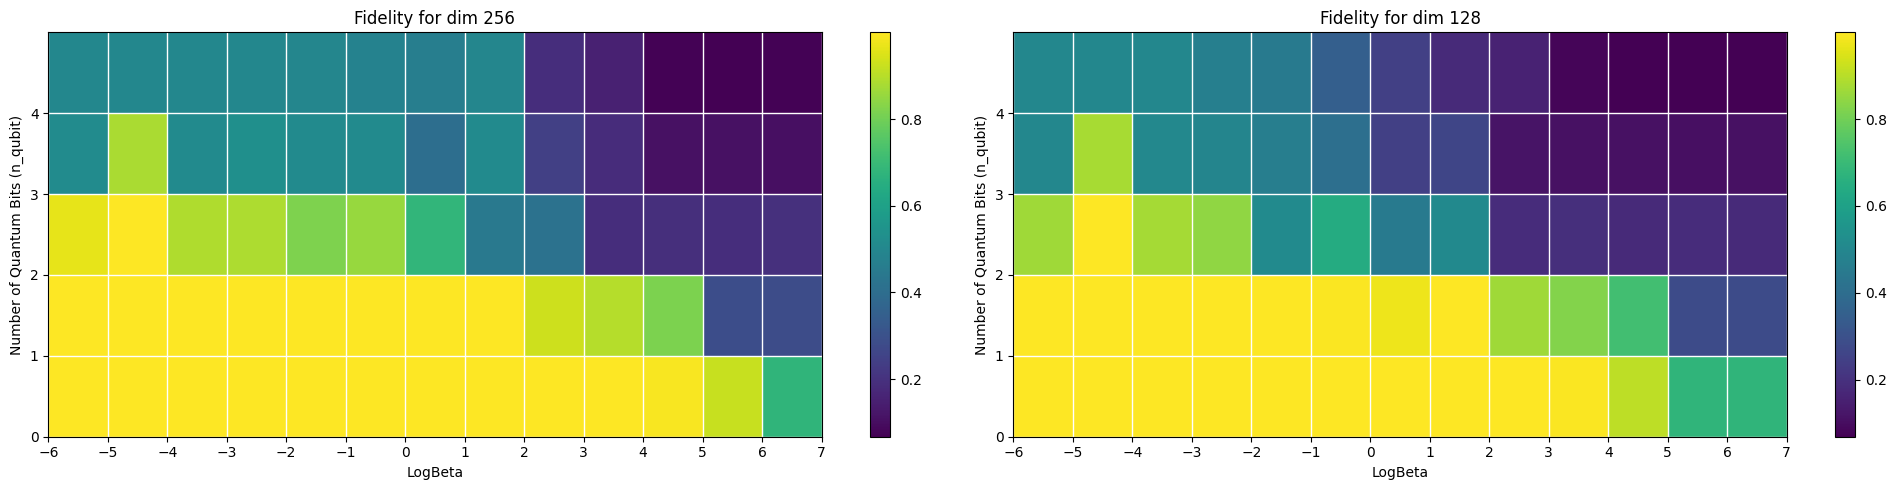

In [122]:
import matplotlib.pyplot as plt
import numpy as np

# Convert data to a NumPy array
data_array = np.array(data)

# Define the dimensions
dimensions = [256, 128]

# Create a large figure with one row and four columns
fig, axs = plt.subplots(1, 2, figsize=(20, 5))  # 修改这里，只有一行四列

# Loop through each dimension value
for i, dim in enumerate(dimensions):
    # Filter data for the specific dimension
    filtered_data = data_array[data_array[:, 0] == dim]

    # Extract columns for number of qubits, logbeta, and fidelity
    n_qubit = filtered_data[:, 1]
    logbeta = filtered_data[:, 2]
    fid = filtered_data[:, 3]

    # Create a matrix for fidelity
    fid_matrix = np.zeros((5, 13))

    for j in range(len(filtered_data)):
        n = int(n_qubit[j] - 1)
        lb = int(logbeta[j] + 6)
        fid_matrix[n, lb] = fid[j]

    # Fidelity heatmap
    im1 = axs[i].imshow(fid_matrix, cmap='viridis', extent=[-6, 7, 0, 5], aspect='auto', origin='lower')
    axs[i].set_title(f'Fidelity for dim {dim}')
    plt.colorbar(im1, ax=axs[i])

# Add labels and gridlines to all subplots
for ax in axs:
    ax.set_xlabel('LogBeta')
    ax.set_ylabel('Number of Quantum Bits (n_qubit)')
    ax.set_xticks(np.arange(-6, 8, 1))
    ax.set_yticks(np.arange(0, 5, 1))
    ax.grid(color='white', linestyle='-', linewidth=1)

# Adjust layout and show the figure
plt.tight_layout()
plt.show()



##### GHZ

C:\Users\86991\AppData\Local\Temp\ipykernel_9348\3690028157.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  n = int(n_qubit[i] - 1)  # Adjust for zero-indexing
C:\Users\86991\AppData\Local\Temp\ipykernel_9348\3690028157.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  lb = int(logbeta[i] + 6)  # Shift logbeta values to positive indices
C:\Users\86991\AppData\Local\Temp\ipykernel_9348\3690028157.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  fid_matrix[n, lb] = fid[i]
C:\Users\86991\AppData\Local\Temp\ipykernel_9348\3690028157.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  n = int(n_qubit[i] - 1)
C:\Users\86991\AppData\Local\Temp\ipykernel_9348\3690028157.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  lb = int(logbeta[i] + 6)
C:\Users\86991\AppData\Local\Temp\ipykernel_9348\3690028157.py:25: ComplexWarning: 

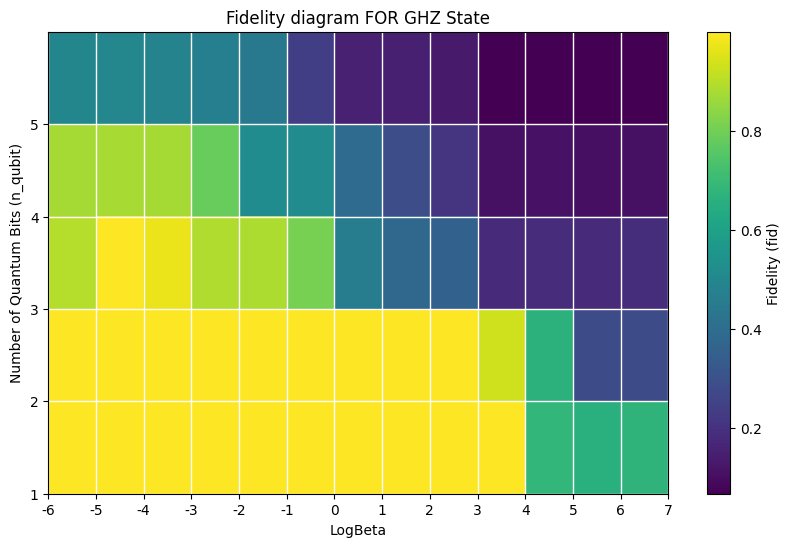

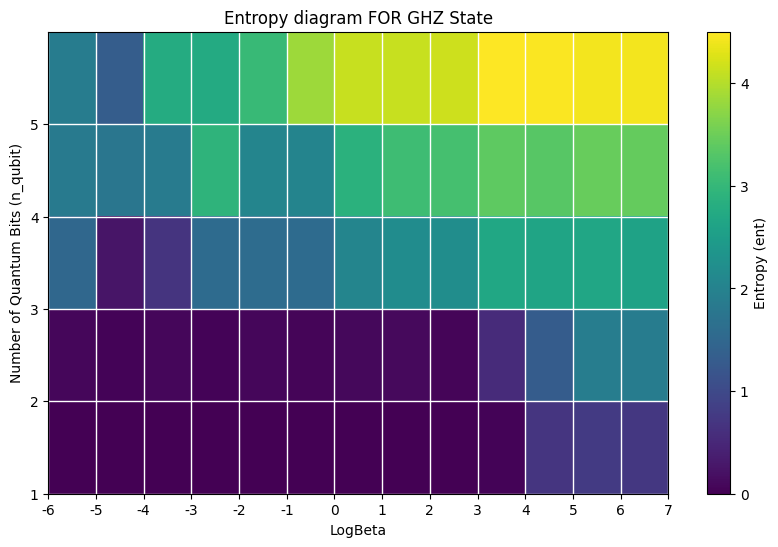

In [111]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'data' is a list or array that you have already defined
data_array = np.array(data)

# Extract the columns for number of qubits, logbeta, and fidelity
n_qubit = data_array[:, 0]
logbeta = data_array[:, 1]
fid = data_array[:, 2]
entropy = data_array[:, 3]


# Create a matrix to fill with fidelity values
fid_matrix = np.zeros((5, 13))
for i in range(len(data)):
    n = int(n_qubit[i] - 1)  # Adjust for zero-indexing
    lb = int(logbeta[i] + 6)  # Shift logbeta values to positive indices
    fid_matrix[n, lb] = fid[i]

ent_matrix = np.zeros((5, 13))  # 根据数据的范围创建一个矩阵
for i in range(len(data)):
    n = int(n_qubit[i] - 1)
    lb = int(logbeta[i] + 6)
    ent_matrix[n, lb] = entropy[i]

# Create the heatmap
plt.figure(figsize=(10, 6))
plt.imshow(fid_matrix, cmap='viridis', extent=[-6, 7, 0, 5], aspect='auto', origin='lower')

# Add colorbar
plt.colorbar(label='Fidelity (fid)')

# Add labels and title
plt.xlabel('LogBeta')
plt.ylabel('Number of Quantum Bits (n_qubit)')
plt.title('Fidelity diagram FOR GHZ State')


# Set x-ticks to be at the edges of the cells
plt.xticks(np.arange(-6, 8, 1), np.arange(-6, 8, 1))

# Set y-ticks to be at the edges of the cells
plt.yticks(np.arange(0, 5, 1), np.arange(1, 6, 1))

# Draw white gridlines at the tick locations
plt.grid(color='white', linestyle='-', linewidth=1)

# Show the plot
plt.show()


# Create the heatmap
plt.figure(figsize=(10, 6))
plt.imshow(ent_matrix, cmap='viridis', extent=[-6, 7, 0, 5], aspect='auto', origin='lower')

# Add colorbar
plt.colorbar(label='Entropy (ent)')

# Add labels and title
plt.xlabel('LogBeta')
plt.ylabel('Number of Quantum Bits (n_qubit)')
plt.title('Entropy diagram FOR GHZ State')


# Set x-ticks to be at the edges of the cells
plt.xticks(np.arange(-6, 8, 1), np.arange(-6, 8, 1))

# Set y-ticks to be at the edges of the cells
plt.yticks(np.arange(0, 5, 1), np.arange(1, 6, 1))

# Draw white gridlines at the tick locations
plt.grid(color='white', linestyle='-', linewidth=1)

# Show the plot
plt.show()


C:\Users\86991\AppData\Local\Temp\ipykernel_9348\853683050.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  n = int(n_qubit[i] - 1)
C:\Users\86991\AppData\Local\Temp\ipykernel_9348\853683050.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  lb = int(logbeta[i] + 6)
C:\Users\86991\AppData\Local\Temp\ipykernel_9348\853683050.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  entropy_matrix[n, lb] = entropy[i]


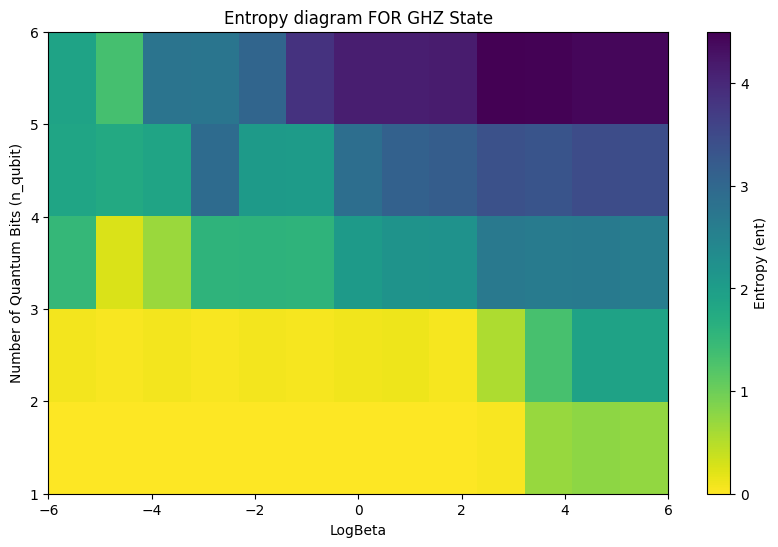

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# 从 data 列表中提取数据并转换为 NumPy 数组
data_array = np.array(data)

# 提取量子比特数、logbeta 和保真度列
n_qubit = data_array[:, 0]
logbeta = data_array[:, 1]
entropy = data_array[:, 3]

# 创建一个矩阵，将 fid 值填充到相应的位置
entropy_matrix = np.zeros((5, 13))  # 根据数据的范围创建一个矩阵
for i in range(len(data)):
    n = int(n_qubit[i] - 1)
    lb = int(logbeta[i] + 6)
    entropy_matrix[n, lb] = entropy[i]

# 创建热图，根据 entropy_matrix 中的值来着色
plt.figure(figsize=(10, 6))
plt.imshow(entropy_matrix, cmap='viridis_r', extent=[-6, 6, 1, 6], aspect='auto', origin='lower')
plt.colorbar(label='Entropy (ent)')
plt.xlabel('LogBeta')
plt.ylabel('Number of Quantum Bits (n_qubit)')
plt.title('Entropy diagram FOR GHZ State')

plt.show()

##### W-state

C:\Users\86991\AppData\Local\Temp\ipykernel_9348\1829499042.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  n = int(n_qubit[i] - 1)
C:\Users\86991\AppData\Local\Temp\ipykernel_9348\1829499042.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  lb = int(logbeta[i] + 6)
C:\Users\86991\AppData\Local\Temp\ipykernel_9348\1829499042.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  fid_matrix[n, lb] = fid[i]


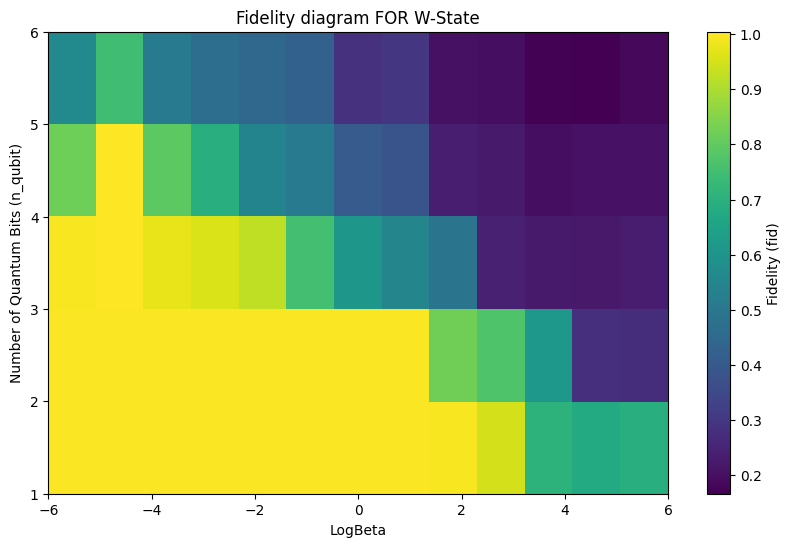

In [113]:
import matplotlib.pyplot as plt
import numpy as np

# 从 data 列表中提取数据并转换为 NumPy 数组
data_array = np.array(data)

# 提取量子比特数、logbeta 和保真度列
n_qubit = data_array[:, 0]
logbeta = data_array[:, 1]
fid = data_array[:, 2]
fid_matrix=np.zeros((5,13))
# 创建一个矩阵，将 fid 值填充到相应的位置
entropy = np.zeros((5, 13))  # 根据数据的范围创建一个矩阵
for i in range(len(data)):
    n = int(n_qubit[i] - 1)
    lb = int(logbeta[i] + 6)
    fid_matrix[n, lb] = fid[i]

# 创建热图，根据 entropy_matrix 中的值来着色
plt.figure(figsize=(10, 6))
plt.imshow(fid_matrix, cmap='viridis', extent=[-6, 6, 1, 6], aspect='auto', origin='lower')
plt.colorbar(label='Fidelity (fid)')
plt.xlabel('LogBeta')
plt.ylabel('Number of Quantum Bits (n_qubit)')
plt.title('Fidelity diagram FOR W-State')

plt.show()


C:\Users\86991\AppData\Local\Temp\ipykernel_21964\79077629.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  n = int(n_qubit[i] - 1)
C:\Users\86991\AppData\Local\Temp\ipykernel_21964\79077629.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  lb = int(logbeta[i] + 6)
C:\Users\86991\AppData\Local\Temp\ipykernel_21964\79077629.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  entropy_matrix[n, lb] = entropy[i]


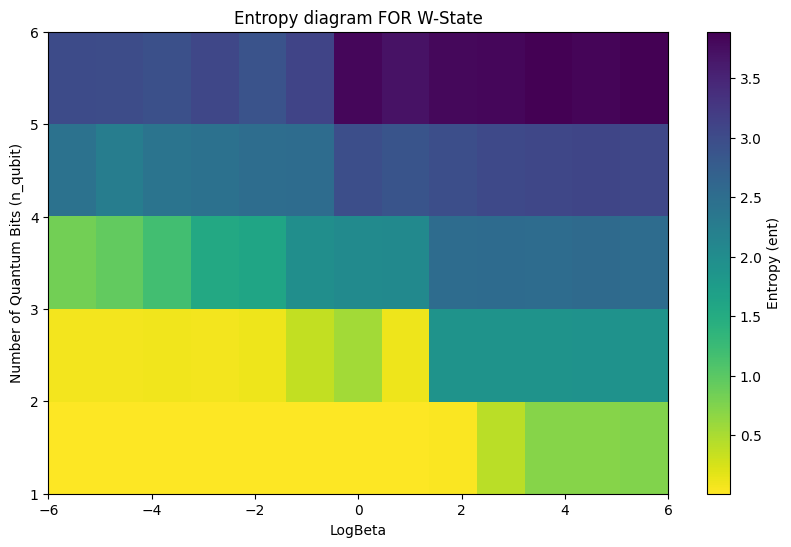

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# 从 data 列表中提取数据并转换为 NumPy 数组
data_array = np.array(data)

# 提取量子比特数、logbeta 和保真度列
n_qubit = data_array[:, 0]
logbeta = data_array[:, 1]
entropy = data_array[:, 3]

# 创建一个矩阵，将 fid 值填充到相应的位置
entropy_matrix = np.zeros((5, 13))  # 根据数据的范围创建一个矩阵
for i in range(len(data)):
    n = int(n_qubit[i] - 1)
    lb = int(logbeta[i] + 6)
    entropy_matrix[n, lb] = entropy[i]

# 创建热图，根据 entropy_matrix 中的值来着色
plt.figure(figsize=(10, 6))
plt.imshow(entropy_matrix, cmap='viridis_r', extent=[-6, 6, 1, 6], aspect='auto', origin='lower')
plt.colorbar(label='Entropy (ent)')
plt.xlabel('LogBeta')
plt.ylabel('Number of Quantum Bits (n_qubit)')
plt.title('Entropy diagram FOR W-State')

plt.show()

##### Zero-state

C:\Users\86991\AppData\Local\Temp\ipykernel_21964\2332439937.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  n = int(n_qubit[i] - 1)
C:\Users\86991\AppData\Local\Temp\ipykernel_21964\2332439937.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  lb = int(logbeta[i] + 6)
C:\Users\86991\AppData\Local\Temp\ipykernel_21964\2332439937.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  fid_matrix[n, lb] = fid[i]


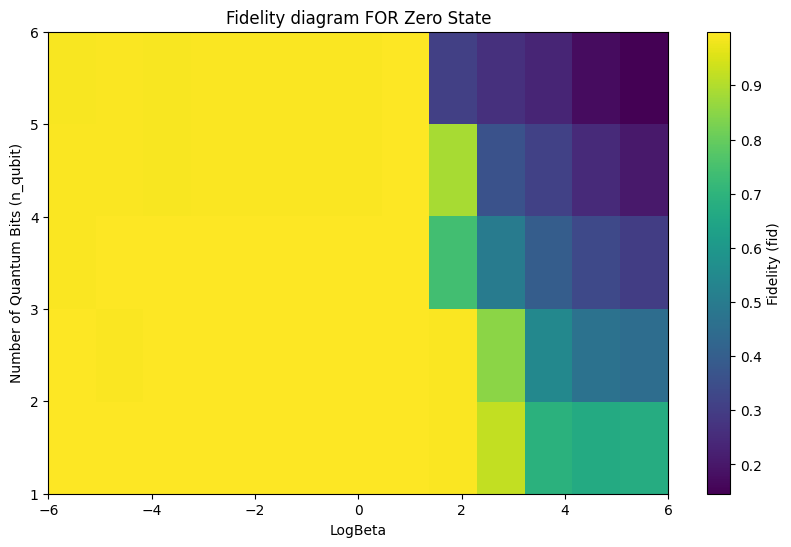

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# 从 data 列表中提取数据并转换为 NumPy 数组
data_array = np.array(data)

# 提取量子比特数、logbeta 和保真度列
n_qubit = data_array[:, 0]
logbeta = data_array[:, 1]
fid = data_array[:, 2]
fid_matrix=np.zeros((5,13))
# 创建一个矩阵，将 fid 值填充到相应的位置
entropy = np.zeros((5, 13))  # 根据数据的范围创建一个矩阵
for i in range(len(data)):
    n = int(n_qubit[i] - 1)
    lb = int(logbeta[i] + 6)
    fid_matrix[n, lb] = fid[i]

# 创建热图，根据 entropy_matrix 中的值来着色
plt.figure(figsize=(10, 6))
plt.imshow(fid_matrix, cmap='viridis', extent=[-6, 6, 1, 6], aspect='auto', origin='lower')
plt.colorbar(label='Fidelity (fid)')
plt.xlabel('LogBeta')
plt.ylabel('Number of Quantum Bits (n_qubit)')
plt.title('Fidelity diagram FOR Zero State')

plt.show()


C:\Users\86991\AppData\Local\Temp\ipykernel_21964\1590311722.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  n = int(n_qubit[i] - 1)
C:\Users\86991\AppData\Local\Temp\ipykernel_21964\1590311722.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  lb = int(logbeta[i] + 6)
C:\Users\86991\AppData\Local\Temp\ipykernel_21964\1590311722.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  entropy_matrix[n, lb] = entropy[i]


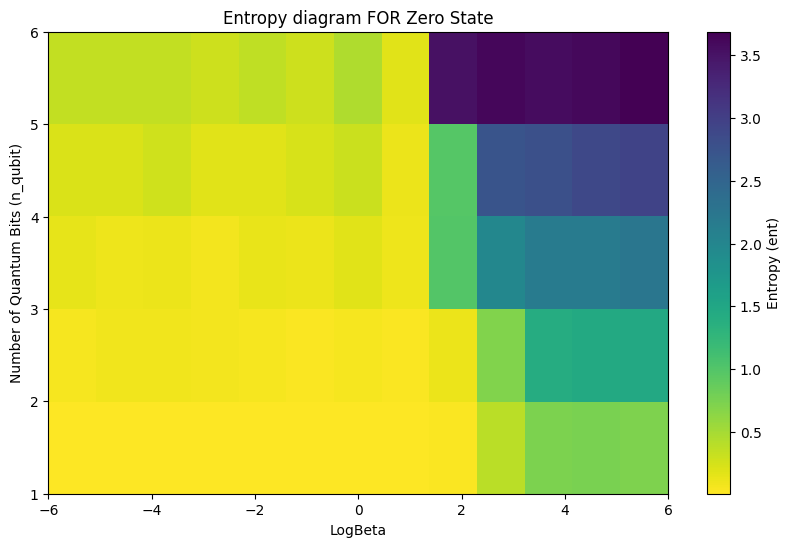

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# 从 data 列表中提取数据并转换为 NumPy 数组
data_array = np.array(data)

# 提取量子比特数、logbeta 和保真度列
n_qubit = data_array[:, 0]
logbeta = data_array[:, 1]
entropy = data_array[:, 3]

# 创建一个矩阵，将 fid 值填充到相应的位置
entropy_matrix = np.zeros((5, 13))  # 根据数据的范围创建一个矩阵
for i in range(len(data)):
    n = int(n_qubit[i] - 1)
    lb = int(logbeta[i] + 6)
    entropy_matrix[n, lb] = entropy[i]

# 创建热图，根据 entropy_matrix 中的值来着色
plt.figure(figsize=(10, 6))
plt.imshow(entropy_matrix, cmap='viridis_r', extent=[-6, 6, 1, 6], aspect='auto', origin='lower')
plt.colorbar(label='Entropy (ent)')
plt.xlabel('LogBeta')
plt.ylabel('Number of Quantum Bits (n_qubit)')
plt.title('Entropy diagram FOR Zero State')

plt.show()

###  Atlas Boreas Cygnus

Take three representative models.

In [54]:
state='GHZ'
mdls = {
    'quantum': ClassicalShadowTransformer(4, -5,state,embed_dim=256).load().eval(),
    'classical': ClassicalShadowTransformer(4, -1,state,embed_dim=256).load().eval(),
    'thermal': ClassicalShadowTransformer(4, 6,state,embed_dim=256).load().eval()}

Chat with the model. Dictionary:

| Number | Symbol |
|--------|--------|
| `1`    | `+`    |
| `2`    | `-`    |
| `3`    | `I`    |
| `4`    | `X`    |
| `5`    | `Y`    |
| `6`    | `Z`    |

* Z-test: `x: ZZZZZ, y:abcd?`, where $a,b,c,d\in\{+,-\}$ 
* X-test: `x: XXXXX, y:abcd?`, where $a,b,c,d\in\{+,-\}$ 
* XZ-test: `x: XXXXZ, y:abcd?`, where $a,b,c,d\in\{+,-\}$ 



#### Collect data:

In [55]:
data = {}
y0 = torch.cartesian_prod(*[torch.tensor([1,2])]*3)
y = torch.cat([y0, torch.zeros(y0.shape[0], dtype=torch.long)[:, None]], 1)
x = torch.zeros_like(y) + 6
data['obs'] = y0.tolist()
with torch.no_grad():
    for name, mdl in mdls.items():
        logit = mdl.transformer(x, y)[:,-1]
        data[name] = logit.tolist()
with open('./data/z_test.dat', 'wb') as f:
    pickle.dump(data, f)
print(x,'\n',y)

tensor([[6, 6, 6, 6],
        [6, 6, 6, 6],
        [6, 6, 6, 6],
        [6, 6, 6, 6],
        [6, 6, 6, 6],
        [6, 6, 6, 6],
        [6, 6, 6, 6],
        [6, 6, 6, 6]]) 
 tensor([[1, 1, 1, 0],
        [1, 1, 2, 0],
        [1, 2, 1, 0],
        [1, 2, 2, 0],
        [2, 1, 1, 0],
        [2, 1, 2, 0],
        [2, 2, 1, 0],
        [2, 2, 2, 0]])


In [56]:
data = {}
y0 = torch.cartesian_prod(*[torch.tensor([1,2])]*3)
y = torch.cat([y0,torch.zeros(y.shape[0], dtype=torch.long)[:,None]],1)
x = torch.zeros_like(y) + 4
data['obs'] = y0.tolist()
with torch.no_grad():
    for name, mdl in mdls.items():
        logit = mdl.transformer(x, y)[:,-1]
        data[name] = logit.tolist()
with open('./data/x_test.dat', 'wb') as f:
    pickle.dump(data, f)
print(x,'\n',y)


tensor([[4, 4, 4, 4],
        [4, 4, 4, 4],
        [4, 4, 4, 4],
        [4, 4, 4, 4],
        [4, 4, 4, 4],
        [4, 4, 4, 4],
        [4, 4, 4, 4],
        [4, 4, 4, 4]]) 
 tensor([[1, 1, 1, 0],
        [1, 1, 2, 0],
        [1, 2, 1, 0],
        [1, 2, 2, 0],
        [2, 1, 1, 0],
        [2, 1, 2, 0],
        [2, 2, 1, 0],
        [2, 2, 2, 0]])


In [57]:
data = {}
y0 = torch.cartesian_prod(*[torch.tensor([1,2])]*3)
y = torch.cat([y0,torch.zeros(y.shape[0], dtype=torch.long)[:,None]],1)
x = torch.zeros_like(y) + 4
x[:,-1] = 6
data['obs'] = y0.tolist()
with torch.no_grad():
    for name, mdl in mdls.items():
        logit = mdl.transformer(x, y)[:,-1]
        data[name] = logit.tolist()
with open('./data/xz_test.dat', 'wb') as f:
    pickle.dump(data, f)
print(x,'\n',y)

tensor([[4, 4, 4, 6],
        [4, 4, 4, 6],
        [4, 4, 4, 6],
        [4, 4, 4, 6],
        [4, 4, 4, 6],
        [4, 4, 4, 6],
        [4, 4, 4, 6],
        [4, 4, 4, 6]]) 
 tensor([[1, 1, 1, 0],
        [1, 1, 2, 0],
        [1, 2, 1, 0],
        [1, 2, 2, 0],
        [2, 1, 1, 0],
        [2, 1, 2, 0],
        [2, 2, 1, 0],
        [2, 2, 2, 0]])


### Density Matrix Reconstruction

Reconstruct density matrices for representative models.

using `rhos.dat`

In [58]:
data = {}
for name, mdl in mdls.items():
    with torch.no_grad():
        rho = mdl.rho().matrix_form()/2**mdl.n_qubit # reconstruction
    data[name] = rho.tolist()
with open('./data/rhos.dat', 'wb') as f:
    pickle.dump(data, f)

### Latent Space Structure

`x` will be a tensor where each row is a unique combination of the numbers 4, 5, and 6 repeated 5 times. The total number of rows will be $3^5$ = 243, since there are 3 choices (4, 5, 6) for each of the 5 positions.

In [23]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
tsne = TSNE(n_components=2)
pca = PCA(n_components=2)
x = torch.cartesian_prod(*[torch.tensor([4,5,6])]*5)

data = {'x': (x-3).tolist()}
for name, mdl in mdls.items():
    with torch.no_grad():
        src = mdl.transformer.embed(x)
        mem = mdl.transformer.encode(src)
    mem = mem.view(mem.shape[0],-1)
    z = tsne.fit_transform(mem)
    # z = pca.fit_transform(mem.numpy())
    
    data[name] = z.tolist()
with open('./data/z_embed.dat', 'wb') as f:
    pickle.dump(data, f)

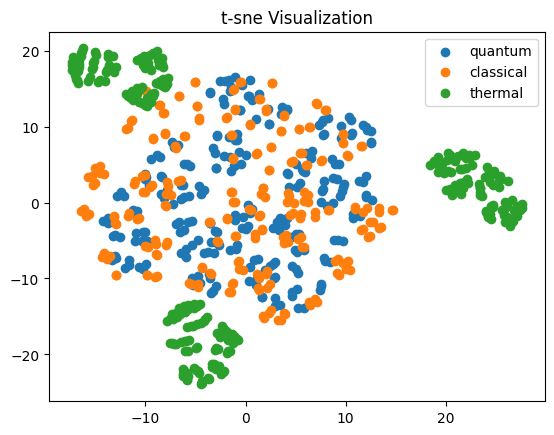

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


with open('./data/z_embed.dat', 'rb') as f:
    data = pickle.load(f)


x_data = data['x']
z_data = {name: data_point for name, data_point in data.items() if name != 'x'}


for name, z_points in z_data.items():
   
    z_points = np.array(z_points)
    plt.scatter(z_points[:, 0], z_points[:, 1], label=name)


plt.title('t-sne Visualization')



plt.legend()


plt.show()


In [35]:
data_x=data['x']
unique_sequences = set(tuple(row) for row in data_x)

# 获取不同数列的数量
num_unique_sequences = len(unique_sequences)

print(f"有 {num_unique_sequences} 种不同的数列。")

有 243 种不同的数列。


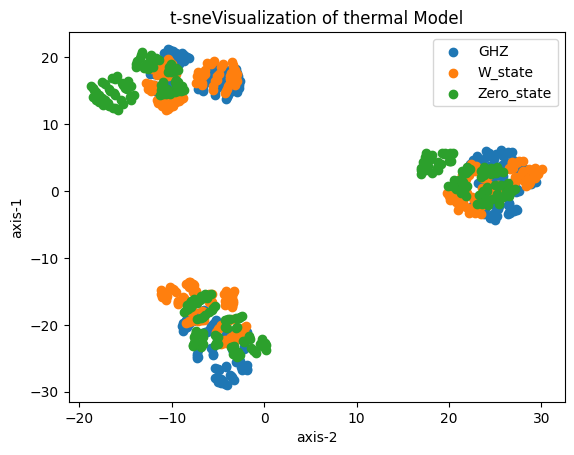

In [27]:
state_list = ['GHZ', 'W_state', 'Zero_state']

data = {'x': (x-3).tolist()}
for state in state_list:
    for name, mdl in mdls.items():
        with torch.no_grad():
            src = mdl.transformer.embed(x)
            mem = mdl.transformer.encode(src)
        mem = mem.view(mem.shape[0],-1)
        z = tsne.fit_transform(mem)
        
        # 将数据以(state, model)的形式保存
        data[(state, name)] = z.tolist()

with open('./data/z_embed.dat', 'wb') as f:
    pickle.dump(data, f)
with open('./data/z_embed.dat', 'rb') as f:
    data = pickle.load(f)

# 选择要可视化的模型，例如 'quantum'
selected_model = 'thermal'

for state in state_list:
    z_points = np.array(data[(state, selected_model)])
    plt.scatter(z_points[:, 0], z_points[:, 1], label=state)

plt.title(f't-sneVisualization of {selected_model} Model')
plt.xlabel('axis-2')
plt.ylabel('axis-1')
plt.legend()
plt.show()


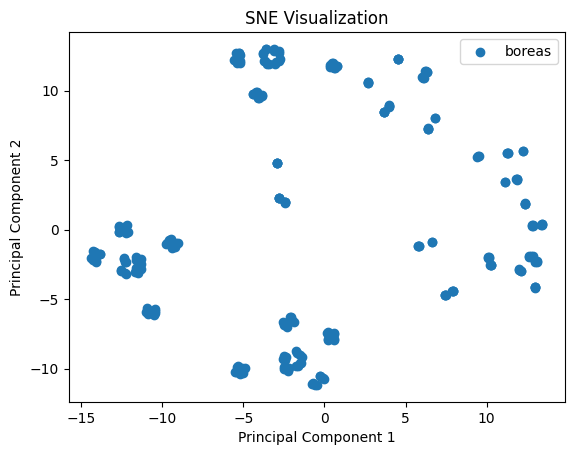

In [37]:
with open('./data/z_embed.dat', 'rb') as f:
    data = pickle.load(f)

# 你关注的名字
selected_names = ['boreas']
# 'atlas', 'boreas', 'cygnus'
# 提取 z_data
z_data = {name: data_point for name, data_point in data.items() if name in selected_names}

# 绘制散点图
for name, z_points in z_data.items():
    z_points = np.array(z_points)
    plt.scatter(z_points[:, 0], z_points[:, 1], label=name)

# 设置图表标题和坐标轴标签
plt.title('SNE Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# 显示图例
plt.legend()

# 显示图表
plt.show()

##### test count

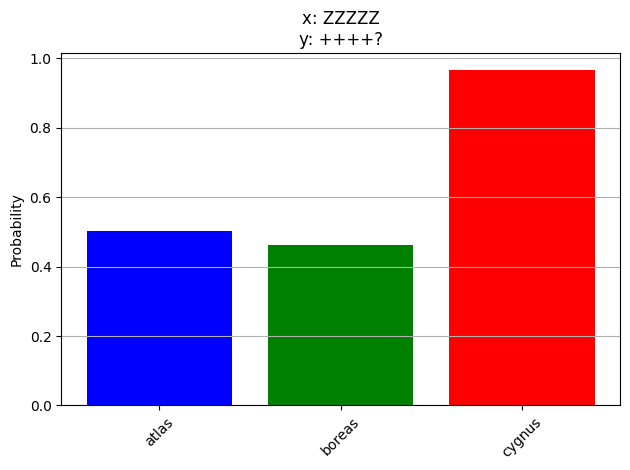

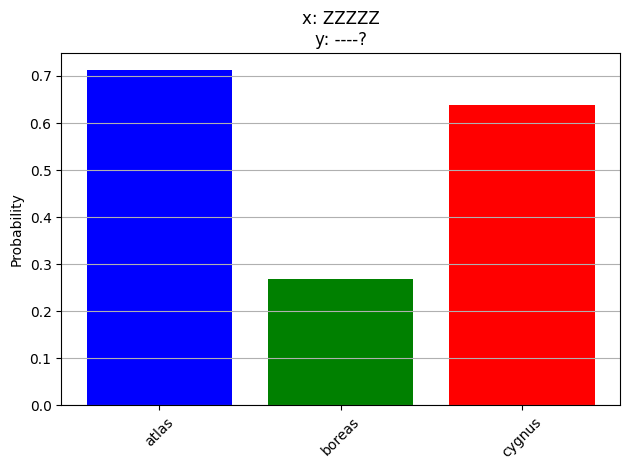

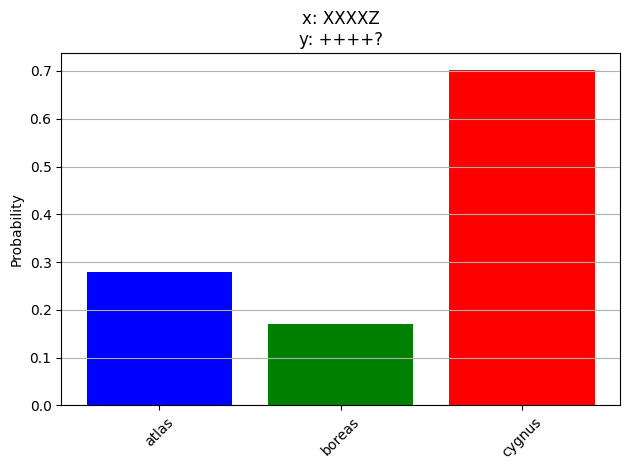

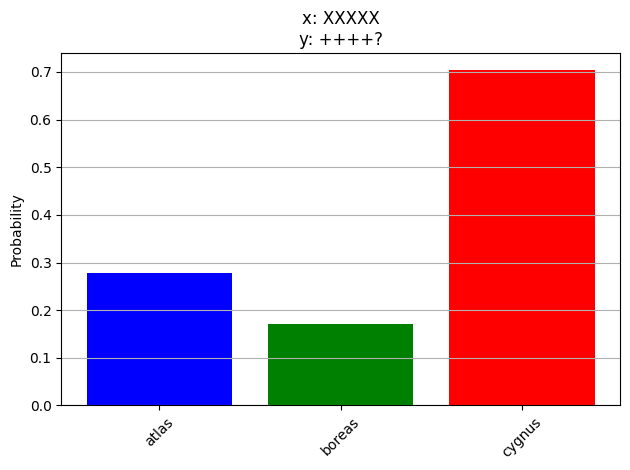

In [38]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

# Load data
notebook_directory = './'  # Replace with your notebook directory path
ztest = pickle.load(open(os.path.join(notebook_directory, 'data/z_test.dat'), 'rb'))
xtest = pickle.load(open(os.path.join(notebook_directory, 'data/x_test.dat'), 'rb'))
xztest = pickle.load(open(os.path.join(notebook_directory, 'data/xz_test.dat'), 'rb'))

# Model names
mdls = ["atlas", "boreas", "cygnus"]

# Function to create bar chart
def chart(test, v, prompt):
    ind = np.where(np.array(test["obs"]) == v)[0][0]
    logit = np.array([test[mdl][ind] for mdl in mdls])
    
    # Adjust the calculation of probabilities if necessary
    probabilities = np.exp(logit - np.max(logit))  # Subtracting the max for numerical stability
    probabilities = probabilities / probabilities.sum(axis=0)

    fig, ax = plt.subplots()
    for i, mdl in enumerate(mdls):
        ax.bar(mdl, probabilities[i], color=['blue', 'green', 'red'][i])
    
    ax.set_title(prompt, fontsize=12)
    ax.set_ylabel('Probability')
    ax.grid(True, axis='y')
    plt.xticks(rotation=45)
    plt.tight_layout()

    return fig, ax

# Now create and display charts
fig1, ax1 = chart(ztest, 1, "x: ZZZZZ\ny: ++++?")
fig2, ax2 = chart(ztest, 2, "x: ZZZZZ\ny: ----?")
fig3, ax3 = chart(xztest, 1, "x: XXXXZ\ny: ++++?")
fig4, ax4 = chart(xtest, 1, "x: XXXXX\ny: ++++?")

plt.show()


##### out-of distribution

In [6]:
rho

DensityMatrix([[ 1.47535905e-033+0.j, -1.71776544e-017+0.j,
                -1.71776544e-017+0.j, ..., -1.44855987e-051+0.j,
                 7.71913420e-051+0.j,  1.00234921e-066+0.j],
               [-1.71776544e-017-0.j,  2.00000000e-001+0.j,
                 2.00000000e-001+0.j, ...,  1.68656306e-035+0.j,
                -8.98741355e-035-0.j, -1.16703851e-050-0.j],
               [-1.71776544e-017-0.j,  2.00000000e-001+0.j,
                 2.00000000e-001+0.j, ...,  1.68656306e-035+0.j,
                -8.98741355e-035-0.j, -1.16703851e-050-0.j],
               ...,
               [-1.44855987e-051-0.j,  1.68656306e-035+0.j,
                 1.68656306e-035+0.j, ...,  1.42224748e-069+0.j,
                -7.57891985e-069-0.j, -9.84142019e-085-0.j],
               [ 7.71913420e-051+0.j, -8.98741355e-035+0.j,
                -8.98741355e-035+0.j, ..., -7.57891985e-069+0.j,
                 4.03868012e-068+0.j,  5.24432885e-084+0.j],
               [ 1.00234921e-066+0.j, -1.16703851e

In [16]:
rho

array([[ 1.47535905e-033, -1.71776544e-017, -1.71776544e-017, ...,
        -1.44855987e-051,  7.71913420e-051,  1.00234921e-066],
       [-1.71776544e-017,  2.00000000e-001,  2.00000000e-001, ...,
         1.68656306e-035, -8.98741355e-035, -1.16703851e-050],
       [-1.71776544e-017,  2.00000000e-001,  2.00000000e-001, ...,
         1.68656306e-035, -8.98741355e-035, -1.16703851e-050],
       ...,
       [-1.44855987e-051,  1.68656306e-035,  1.68656306e-035, ...,
         1.42224748e-069, -7.57891985e-069, -9.84142019e-085],
       [ 7.71913420e-051, -8.98741355e-035, -8.98741355e-035, ...,
        -7.57891985e-069,  4.03868012e-068,  5.24432885e-084],
       [ 1.00234921e-066, -1.16703851e-050, -1.16703851e-050, ...,
        -9.84142019e-085,  5.24432885e-084,  6.80989439e-100]])

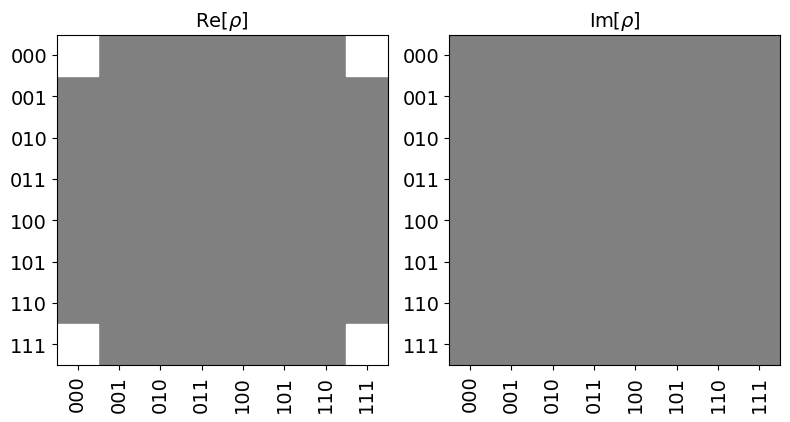

In [19]:
import matplotlib.pyplot as plt
from qiskit.visualization import plot_state_city, plot_state_hinton
from qiskit.quantum_info import DensityMatrix
w_vec=ghz_state(3)[0]
rho=DensityMatrix(w_vec)
# Plot the density matrix
# plot_state_city(rho)

plot_state_hinton(rho)




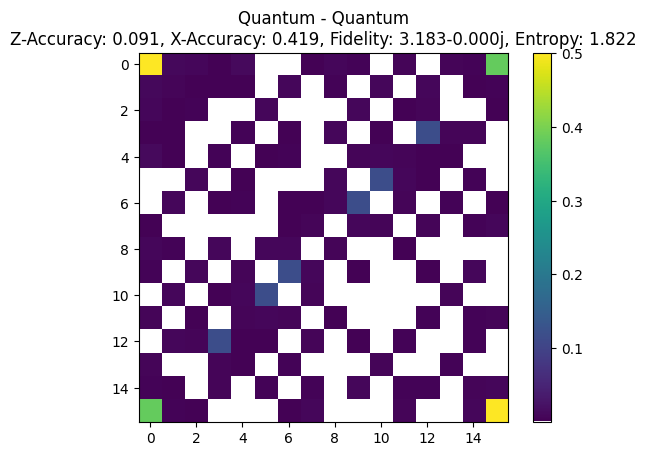

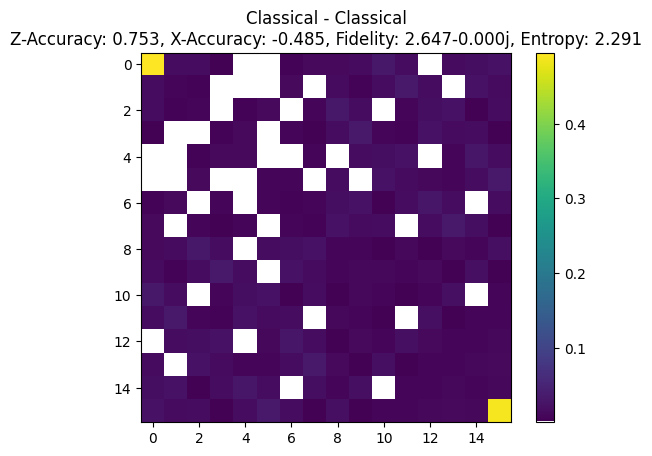

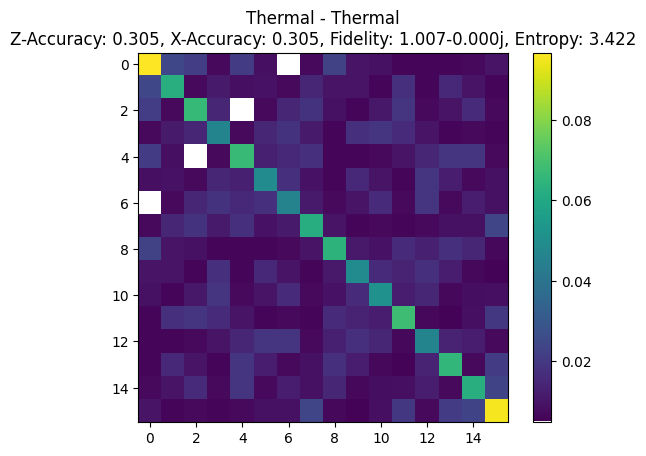

In [59]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy.linalg import eigh
from scipy.linalg import sqrtm
from matplotlib.colors import LinearSegmentedColormap

# Load data
notebook_directory = './'  # Adjust as needed
z_test = pickle.load(open(os.path.join(notebook_directory, 'data/z_test.dat'), 'rb'))
x_test = pickle.load(open(os.path.join(notebook_directory, 'data/x_test.dat'), 'rb'))
xz_test = pickle.load(open(os.path.join(notebook_directory, 'data/xz_test.dat'), 'rb'))
rhos = pickle.load(open(os.path.join(notebook_directory, 'data/rhos.dat'), 'rb'))

mdls = list(rhos.keys())
col = {"quantum": "blue", "classical": "green", "thermal": "red"}
phase = {"quantum": "Quantum", "classical": "Classical", "thermal": "Thermal"}

# Define additional functions
def calculate_accuracy(test_data, model):
    # Placeholder for accuracy calculation - adjust as needed
    return np.mean(test_data[model])

def calculate_fidelity(rho):
    # Simplified fidelity calculation for rho with itself
    sqrt_rho = sqrtm(rho)
    product = np.dot(sqrt_rho, np.dot(rho, sqrt_rho))
    return np.trace(sqrtm(product))**2

def calculate_entropy(rho):
    eigenvalues, _ = eigh(rho)
    return -np.sum([p * np.log2(p) for p in eigenvalues if p > 0])

def make_colormap():
    # Create a color list ranging from white to the colors of the 'viridis' colormap
    colors = ['white'] + [plt.cm.viridis(i) for i in range(1, 256)]
    return LinearSegmentedColormap.from_list("custom_viridis", colors, N=256)


# 使用自定义的颜色映射
custom_cmap = make_colormap()

for mdl in mdls:
    rho = rhos[mdl]

    # 计算指标
    zacc = calculate_accuracy(z_test, mdl)
    xacc = calculate_accuracy(x_test, mdl)
    fid = calculate_fidelity(rho)
    ent = calculate_entropy(rho)

    # 使用自定义颜色映射进行可视化
    plt.imshow(np.abs(rho), cmap=custom_cmap)
    plt.colorbar()
    plt.title(f"{phase[mdl]} - {mdl.capitalize()}\nZ-Accuracy: {zacc:.3f}, X-Accuracy: {xacc:.3f}, Fidelity: {fid:.3f}, Entropy: {ent:.3f}")
    plt.show()

##### clustering figure

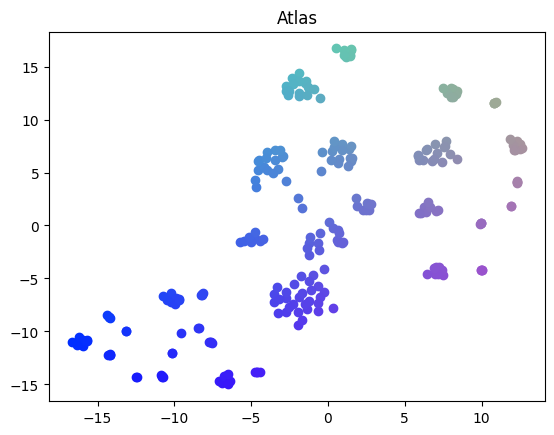

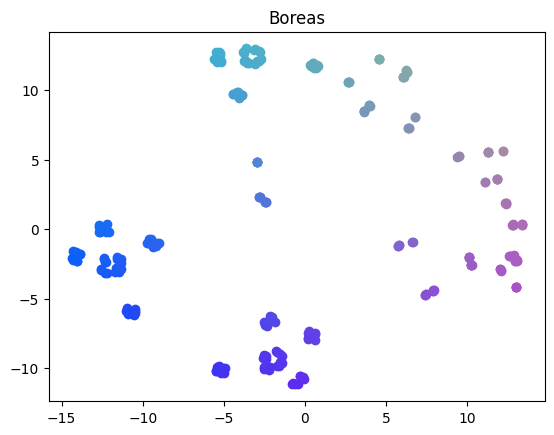

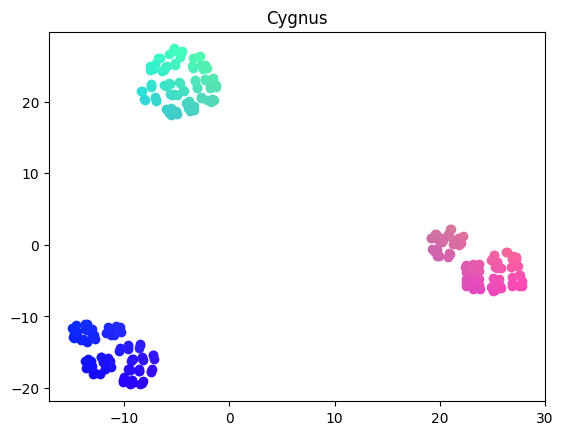

In [41]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba

# Load data
notebook_directory = './'  # Adjust as needed
data = pickle.load(open(os.path.join(notebook_directory, 'data/z_embed.dat'), 'rb'))

mdls = ["atlas", "boreas", "cygnus"]
def scheme_atlas(x):
    zloc = [i for i, v in enumerate(x) if v == 3]
    return zloc if zloc else x.count(1)

def scheme_boreas(x):
    return [i for i, v in enumerate(x) if v == 3]

def scheme_cygnus(x):
    return [x[0], x[-1]]

scheme = {
    "atlas": scheme_atlas,
    "boreas": scheme_boreas,
    "cygnus": scheme_cygnus
}

mark = {
    "atlas": [[1, 1, 1, 1, 1], [2, 2, 2, 2, 2], [1, 1, 2, 2, 2], [1, 1, 1, 2, 2], 
              [3, 1, 1, 1, 1], [1, 3, 3, 1, 1], [1, 3, 1, 3, 3], [3, 1, 3, 3, 3], 
              [3, 3, 3, 3, 3]],
    "boreas": [[1, 1, 1, 1, 1], [2, 2, 2, 2, 2], [1, 1, 3, 1, 1], [1, 3, 1, 1, 1], 
               [1, 1, 3, 3, 1], [1, 3, 3, 1, 1], [3, 1, 1, 3, 3], [3, 1, 3, 3, 3], 
               [1, 3, 3, 3, 3], [3, 3, 3, 3, 3]],
    "cygnus": [[3, 2, 3, 1, 3], [3, 2, 2, 2, 3], [3, 3, 3, 3, 3], [1, 3, 3, 3, 2], 
               [1, 3, 2, 3, 2], [1, 2, 3, 2, 2]]
}


def colfunc(x, y):
    # Simple example: normalize x and y, then use them to create a color
    x_normalized = (x - min_x) / (max_x - min_x)
    y_normalized = (y - min_y) / (max_y - min_y)
    return (x_normalized, y_normalized, 1 - x_normalized * y_normalized)

# Assuming data[mdl] is a list of [x, y] points
all_points = [point for sublist in data.values() for point in sublist]
min_x, max_x = min(p[0] for p in all_points), max(p[0] for p in all_points)
min_y, max_y = min(p[1] for p in all_points), max(p[1] for p in all_points)

def visualize(mdl):
    for point in data[mdl]:
        plt.scatter(point[0], point[1], color=colfunc(point[0], point[1]))

for model in mdls:
    plt.figure()
    visualize(model)
    plt.title(model.capitalize())
    plt.show()


## trying

In [42]:
describe_statevector(ghz_state(5)[0])

'((0.7071067811865475+0j)) |00000⟩ + ((0.7071067811865475+0j)) |11111⟩'

In [43]:
from qiskit import QuantumRegister,QuantumCircuit, Aer, execute, transpile
from qiskit.quantum_info import Statevector
import numpy as np
import random
def ghz_state(n_qubit):
    """ Create a GHZ state for n_qubit qubits and return its state vector. """
    circuit = QuantumCircuit(n_qubit)
    circuit.h(0)
    for qubit in range(1, n_qubit):
        circuit.cx(0, qubit)
    return Statevector.from_instruction(circuit),circuit

def F_gate(circ, q, i, j, n, k):
    theta = np.arccos(np.sqrt(1/(n-k+1)))
    circ.ry(-theta, q[j])       
    circ.cz(q[i], q[j])
    circ.ry(theta, q[j])
    circ.barrier(q[i])

def cxrv(circ, q, i, j):
    circ.h(q[i])
    circ.h(q[j])
    circ.cx(q[j], q[i])
    circ.h(q[i])
    circ.h(q[j])
    circ.barrier(q[i], q[j])

def w_state(n_qubit):
    q = QuantumRegister(n_qubit)
    W_states = QuantumCircuit(q)

    W_states.x(q[n_qubit-1])  # Start with the last qubit in state |1>

    # Apply F gates
    for i in range(n_qubit-1, 0, -1):
        F_gate(W_states, q, i, i-1, n_qubit, n_qubit-i)

    # Apply the controlled NOT gates
    for i in range(n_qubit-1, 0, -1):
        cxrv(W_states, q, i-1, i)
    return Statevector.from_instruction(W_states),W_states

def shadow(n_qubit, n_sample):
    """ Generate a list of random Pauli strings. """
    paulis = [ 'X', 'Y', 'Z']
    return [''.join(random.choice(paulis) for _ in range(n_qubit)) for _ in range(n_sample)]

def measure(state_vector, obs_list):
    """ Measure the given state vector with each observable in 'obs_list'. """
    results = []
    for obs in obs_list:
        n_qubit = len(obs)

        # Create a circuit from the state vector
        circuit = QuantumCircuit(n_qubit, n_qubit)  # add classical bits for measurement
        circuit.initialize(state_vector, range(n_qubit))  # initialize the state vector

        # Apply gates based on the observable
        for i, o in enumerate(obs):
            if o == 'X':
                circuit.h(i)
            elif o == 'Y':
                circuit.sdg(i)
                circuit.h(i)
        # Measure all qubits
        circuit.measure(range(n_qubit), range(n_qubit))

        # Execute the circuit
        backend = Aer.get_backend('qasm_simulator')
        transpiled_circuit = transpile(circuit, backend)
        job = execute(transpiled_circuit, backend, shots=1)
        result = job.result()
        counts = result.get_counts(transpiled_circuit)
        # Extract the measurement result
        measurement_result = list(counts.keys())[0]
        results.append(measurement_result)

    return results
# Rest of your code (ghz_state, w_state, shadow) remains the same
def describe_statevector(statevector):
   
    if not isinstance(statevector, Statevector):
        raise ValueError("Input must be a Statevector.")

  
    num_qubits = int(np.log2(len(statevector)))

    # 描述态
    state_description = ""
    for i, amplitude in enumerate(statevector):
        if not np.isclose(amplitude, 0):
            # 将索引转换为二进制字符串
            binary_state = format(i, f'0{num_qubits}b')
            # 添加到描述
            if state_description != "":
                state_description += " + "
            state_description += f"({amplitude}) |{binary_state}⟩"

    return state_description





In [44]:
# Example usage
n_qubit = 6
ghz,circuit_ghz = ghz_state(n_qubit)
w,circuit_w = w_state(n_qubit)

n_sample = 5
pauli_list = shadow(n_qubit, n_sample)

print(pauli_list)
measurement_ghz = measure(ghz, pauli_list)
measurement_w = measure(w, pauli_list)

print("Circuit for ghz:")
print(circuit_ghz.draw())
print("\nStatevector:")
print(describe_statevector(ghz))

print(f"GHZ Measurements: {measurement_ghz}")
print("Circuit for w:")
print(circuit_w.draw())
print("\nStatevector:")
print(describe_statevector(w))
print(f"W Measurements: {measurement_w}")

['XXZXYX', 'XZZYXZ', 'XZZXYY', 'ZZZXZY', 'ZZYXZX']
Circuit for ghz:
     ┌───┐                         
q_0: ┤ H ├──■────■────■────■────■──
     └───┘┌─┴─┐  │    │    │    │  
q_1: ─────┤ X ├──┼────┼────┼────┼──
          └───┘┌─┴─┐  │    │    │  
q_2: ──────────┤ X ├──┼────┼────┼──
               └───┘┌─┴─┐  │    │  
q_3: ───────────────┤ X ├──┼────┼──
                    └───┘┌─┴─┐  │  
q_4: ────────────────────┤ X ├──┼──
                         └───┘┌─┴─┐
q_5: ─────────────────────────┤ X ├
                              └───┘

Statevector:
((0.7071067811865475+0j)) |000000⟩ + ((0.7071067811865475+0j)) |111111⟩
GHZ Measurements: ['110001', '011000', '011111', '010111', '110111']
Circuit for w:
         ┌──────────┐                                                      »
q86_0: ──┤ Ry(-π/4) ├──────────────────────────────────────────────────────»
       ┌─┴──────────┴─┐                                                    »
q86_1: ┤ Ry(-0.95532) ├────────────────────────────────────────

start W state 3-qubit on QasmSimulator('qasm_simulator') N= 1024 07/01/2024 15:11:12
end   W state 3-qubit on QasmSimulator('qasm_simulator') N= 1024 07/01/2024 15:11:12
start W state 4-qubit  QasmSimulator('qasm_simulator') N= 1024 07/01/2024 15:11:13
end   W state 4-qubit on QasmSimulator('qasm_simulator') N= 1024 07/01/2024 15:11:13
start W state 5-qubit on QasmSimulator('qasm_simulator') N= 1024 07/01/2024 15:11:13
end   W state 5-qubit on QasmSimulator('qasm_simulator') N= 1024 07/01/2024 15:11:13


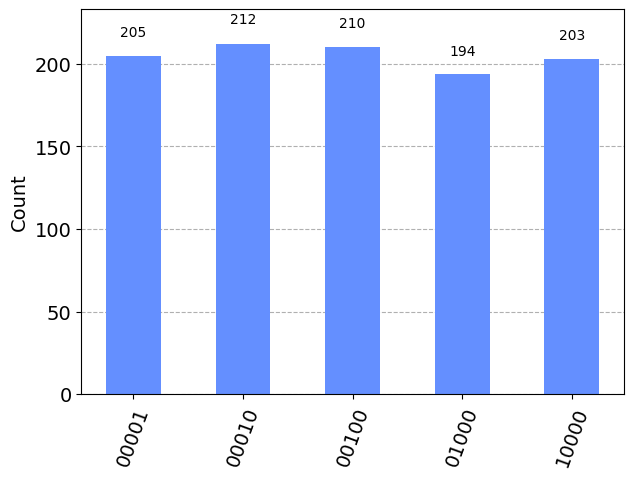

In [45]:
# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
from pprint import pprint

# importing Qiskit
from qiskit import Aer, IBMQ
# from qiskit.providers.ibmq import least_busy 
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram
flag_qx2 = True
backend = Aer.get_backend('qasm_simulator')  
if backend.name == 'ibmqx4':
    flag_qx2 = False
# Here, two useful routine
# Define a F_gate
def F_gate(circ,q,i,j,n,k) :
    theta = np.arccos(np.sqrt(1/(n-k+1)))
    circ.ry(-theta,q[j])       
    circ.cz(q[i],q[j])
    circ.ry(theta,q[j])
    circ.barrier(q[i])
# Define the cxrv gate which uses reverse CNOT instead of CNOT
def  cxrv(circ,q,i,j) :
    circ.h(q[i])
    circ.h(q[j])
    circ.cx(q[j],q[i])
    circ.h(q[i])
    circ.h(q[j])
    circ.barrier(q[i],q[j])
# 3-qubit W state
n = 3
q = QuantumRegister(n) 
c = ClassicalRegister(n)

W_states = QuantumCircuit(q,c) 

W_states.x(q[2]) #start is |100>
F_gate(W_states,q,2,1,3,1) # Applying F12
F_gate(W_states,q,1,0,3,2) # Applying F23

if flag_qx2 : # option ibmqx2 
    W_states.cx(q[1],q[2]) # cNOT 21
    W_states.cx(q[0],q[1]) # cNOT 32
    
else :        # option ibmqx4  
    cxrv(W_states,q,1,2)
    cxrv(W_states,q,0,1)

for i in range(3) :
    W_states.measure(q[i] , c[i]) 

shots = 1024
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('start W state 3-qubit on', backend, "N=", shots,time_exp)
result = execute(W_states, backend=backend, shots=shots)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('end   W state 3-qubit on', backend, "N=", shots,time_exp)
plot_histogram(result.result().get_counts(W_states))
# 4-qubit W state
n = 4
q = QuantumRegister(n) 
c = ClassicalRegister(n)
W_states = QuantumCircuit(q,c) 

W_states.x(q[3]) #start is |1000>
F_gate(W_states,q,3,2,4,1) # Applying F12
F_gate(W_states,q,2,1,4,2) # Applying F23
F_gate(W_states,q,1,0,4,3) # Applying F34        
cxrv(W_states,q,2,3) # cNOT 21
if flag_qx2 : # option ibmqx2  
    W_states.cx(q[1],q[2]) # cNOT 32
    W_states.cx(q[0],q[1]) # cNOT 43

else :        # option ibmqx4 
    cxrv(W_states,q,1,2)
    cxrv(W_states,q,0,1)

for i in range(4) :
    W_states.measure(q[i] , c[i]) 

# circuits = ['W_states']

shots = 1024
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('start W state 4-qubit ', backend, "N=", shots,time_exp)
result = execute(W_states, backend=backend, shots=shots)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('end   W state 4-qubit on', backend, "N=", shots,time_exp)
plot_histogram(result.result().get_counts(W_states))
# 5-qubit W state
n = 5
q = QuantumRegister(n) 
c = ClassicalRegister(n)
W_states = QuantumCircuit(q,c) 

W_states.x(q[4]) #start is |10000>
F_gate(W_states,q,4,3,5,1) # Applying F12
F_gate(W_states,q,3,2,5,2) # Applying F23
F_gate(W_states,q,2,1,5,3) # Applying F34
F_gate(W_states,q,1,0,5,4) # Applying F45
W_states.cx(q[3],q[4]) # cNOT 21
cxrv(W_states,q,2,3)   # cNOT 32
if flag_qx2 : # option ibmqx2 
    W_states.cx(q[1],q[2]) # cNOT 43
    W_states.cx(q[0],q[1]) # cNOT 54
    
else :        # option ibmqx4 
    cxrv(W_states,q,1,2)
    cxrv(W_states,q,0,1)     
    
for i in range(5) :
    W_states.measure(q[i] , c[i]) 

shots = 1024
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('start W state 5-qubit on', backend, "N=", shots,time_exp)
result = execute(W_states, backend=backend, shots=shots)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('end   W state 5-qubit on', backend, "N=", shots,time_exp)
plot_histogram(result.result().get_counts(W_states))

In [46]:
ghz=ghz_state(4)[0]
obs=['YYZZ']
measure_list=[]
for i in range(5000):
    measure_list.append(measure(ghz,obs))

#print(measure_list)
unique, counts = np.unique(measure_list, return_counts=True)

dict(zip(unique, counts))

KeyboardInterrupt: 

In [ ]:
import os
import pickle
import torch
from tqdm import tqdm

def reverse_out_in_samples(file_path):
    # 读取原始的数据文件
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    
    # 获取 'obs' 和 'out' 数据
    all_obs = data['obs']
    all_out = data['out']

    # 反转 'out' 中的每个 PyTorch 张量
    reversed_out = [torch.flip(measurement, dims=[0]) for out in all_out for measurement in out]

    # 将修改后的数据保存回文件
    modified_data = {'obs': all_obs, 'out': reversed_out}
    with open(file_path, 'wb') as file:
        pickle.dump(modified_data, file)

# 指定包含 pickle 文件的目录
directory_path = './sample'

# 获取所有 .pkl 文件
pkl_files = [f for f in os.listdir(directory_path) if f.endswith('.pkl')]

# 使用 tqdm 显示进度条
for filename in tqdm(pkl_files, desc="Processing files"):
    # 构建完整的文件路径
    file_path = os.path.join(directory_path, filename)

    # 反转该文件中的 'out' 数据
    reverse_out_in_samples(file_path)


Processing files: 100%|██████████| 37/37 [05:15<00:00,  8.53s/it]


In [ ]:
import os
import pickle
import torch
from tqdm import tqdm

def reshape_out(file_path, num_elements_per_tensor=200):
    # 读取原始的数据文件
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    
    # 获取 'obs' 和 'out' 数据
    all_obs = data['obs']
    all_out = data['out']

    # 重新构造 'out'，将扁平的列表分割为多个张量
    reshaped_out = [torch.stack(all_out[i:i + num_elements_per_tensor]) for i in range(0, len(all_out), num_elements_per_tensor)]

    # 将修改后的数据保存回文件
    modified_data = {'obs': all_obs, 'out': reshaped_out}
    with open(file_path, 'wb') as file:
        pickle.dump(modified_data, file)

# 指定包含 pickle 文件的目录
directory_path = './sample'

# 获取所有 .pkl 文件
pkl_files = [f for f in os.listdir(directory_path) if f.endswith('.pkl')]

# 使用 tqdm 显示进度条
for filename in tqdm(pkl_files, desc="Reshaping files"):
    # 构建完整的文件路径
    file_path = os.path.join(directory_path, filename)

    # 重新构造该文件中的 'out' 数据
    reshape_out(file_path)


Reshaping files: 100%|██████████| 37/37 [02:09<00:00,  3.50s/it]


In [ ]:
with open('./sample/GHZ_5_10.pkl', 'rb') as file:
    data = pickle.load(file)
    
    # 获取 'obs' 和 'out' 数据
all_obs = data['obs']
all_out = data['out']
random_index = random.randint(0, len(all_obs) - 1)
obs = all_obs[random_index]
out = all_out[random_index]

In [ ]:
obs.shape

torch.Size([10, 5])

In [ ]:
out

tensor([[0, 1, 1, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0],
        [1, 1, 1, 1, 0]])

In [ ]:
with open('./sample/GHZ_5_400.pkl', 'rb') as file:
    data = pickle.load(file)
    
    # 获取 'obs' 和 'out' 数据
all_obs = data['obs']
all_out = data['out']
random_index = random.randint(0, len(all_obs) - 1)
obs = all_obs[random_index]
out = all_out[random_index]

In [ ]:
out

tensor([[1, 1, 0, 0, 1],
        [0, 1, 0, 1, 0],
        [1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1],
        [1, 1, 1, 0, 1],
        [0, 1, 0, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1],
        [1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 0, 1],
        [0, 0, 1, 1, 0],
        [0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 1],
        [1, 0, 0, 1, 0],
        [1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1],
        [0, 1, 0, 1, 0],
        [0, 1, 0, 0, 0],
        [1, 1, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1],
        [1, 1, 1, 1, 0],
        [1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [1, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 1, 0, 1],
        [1, 0, 0, 0, 0],
        [1, 0, 1, 0, 1],
        [1, 0, 1, 1, 1],
        [0, 0, 1, 0, 1],
        [0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 0, 1],


In [ ]:
obs.shape

torch.Size([400, 5])

In [ ]:
shadow=Shadow(obs,out)

In [ ]:
shadow.obs.shape

torch.Size([400, 5])

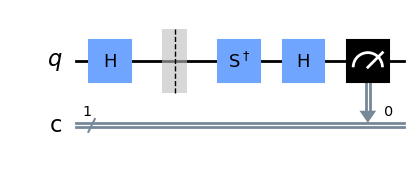

In [5]:
def Y_measurement(qc,qubit,cbit):
    qc.sdg(qubit)
    qc.h(qubit)
    qc.measure(qubit,cbit)
    return qc

circuit = QuantumCircuit(1,1)
circuit.h(0)
circuit.barrier()


Y_measurement(circuit, 0, 0)

circuit.draw(output='mpl') 

d:\programing\Anaconda\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


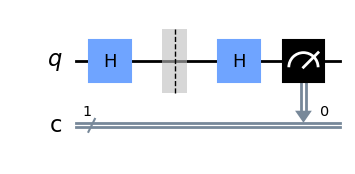

In [7]:
def X_measurement(qc,qubit,cbit):
    qc.h(qubit)
    qc.measure(qubit,cbit)
    return qc

circuit = QuantumCircuit(1,1)
circuit.h(0)
circuit.barrier()


X_measurement(circuit, 0, 0)

circuit.draw(output='mpl') 